## Run, Dont Read

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch as t
from torch import Tensor
from torch.nn import functional as F
from jaxtyping import Float, Int, Bool
from tqdm import tqdm
import copy
from transformer_lens import utils, ActivationCache
from transformer_lens.hook_points import HookPoint
from typing import List, Optional, Callable, Tuple, Dict, Literal, Set, Union        
import argparse
from Patching.ActivationPatching import ActivationPatching
from Patching.PathPatching import PathPatching
from utils.visualization import heat_map_path_patching, heat_map_layer_pos

import gc
from IPython import get_ipython
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow

from dataset.loader import load_dataset
from utils.metrics import ave_logit_diff
from utils.model_loader import load_tokenizer, load_hooked_transformer,load_transformer
from utils.dataset_loader import predict_target_token
from utils.data_io import create_folder, save_circuit, save_circuit, load_circuit, save_dict, set_PATH
from utils.utils import activation_patterns
from utils.eval_circuit import batch_evaluate_circiut, print_statistics

from circuits.circuits_PP import *
from Patching.parser import parser
from Patching.AutomatedPathPatching import automated_PP
from dataset.loader import get_dataloader

ipython = get_ipython()
is_notebook =  ipython is not None

print("running as notebook: ", is_notebook)
t.autograd.set_grad_enabled(False)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


running as notebook:  True


## Add Arguments

In [3]:
is_notebook = get_ipython()
ipython =  is_notebook is not None

if is_notebook:
    # TODO: remove q,v,k
    input_args = [
        #
        #"--task=Induction",
        #"--task=GreaterThan",
        #"--task=GenderedPronouns",
        "--task=IOI",
        #"--task=Docstring",
        
        
        "--model_name=gpt2",
        #"--model_name=gpt2-large",
        #"--model_name=Qwen/Qwen2.5-0.5B",
        "--min_value_threshold=0.01",
        "--importance_threshold=2.5",
        
        "--N=100",
        "--device=cuda",
        "--out_path=/mnt/lustre/work/eickhoff/esx670/res_final/",
        "--cache_dir=/mnt/lustre/work/eickhoff/esx670/llm_weights",
        "--seed=12345432",
        "--calc_FLOPS", 
        "--show",
        #"--verbose" ,
        "--save_every_x_steps=100", 
        #"--save_text", 
        #"--save_img"
    ]
    
    
    args = parser.parse_args(input_args)
else:
    args = parser.parse_args()
    
    
# No Circuit:
PRUNING_CIRCUIT = None
    
if PRUNING_CIRCUIT is None:
    result_folder = f"{args.model_name}/{args.task}/{args.patching_method}/automatic/{args.metric}/min_value_threshold-{args.min_value_threshold}/importance_threshold_{args.importance_threshold}"
else:
    result_folder = f"{args.model_name}/{args.task}/APP/{args.metric}/{args.mode}/min_value_threshold-{args.min_value_threshold}/importance_threshold_{args.importance_threshold}"

if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = os.path.join(args.out_path, result_folder)

create_folder(subfolder)  
set_PATH(args.out_path)

## Manual Path Patching

In [47]:

receiver_heads = []
PRUNING_CIRCUIT = None

if args.patching_method == "activation":
    ap = ActivationPatching(
        model_name=args.model_name, 
        task=args.task, 
        patching_method=args.patching_method, 
        metric_name=args.metric, 
        N=args.N, 
        device=args.device, 
        seed=args.seed, )
elif args.patching_method == "path":
    pp = PathPatching(
        model_name=args.model_name, 
        task=args.task, 
        patching_method=args.patching_method, 
        metric_name=args.metric, 
        N=args.N, 
        device=args.device, 
        patch_mlp=args.patch_mlp,
        seed=args.seed, 
        cache_dir=args.cache_dir
    )


loading gpt2 as HookedTransformer
use float 32
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cpu
load gpt2 tokenizer
using gpt2 model in IOI dataset
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7f9348c57210>


KeyboardInterrupt: 

In [ ]:
receiver_heads = []

done cleaning


 ... (more hidden) ...


number of FLOPS: 0.00 GFLOPs
total number of Forward Passes: 434


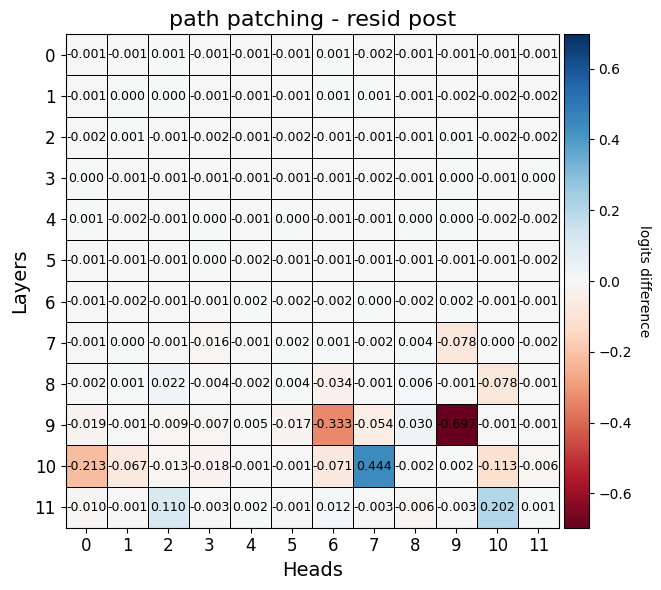

In [ ]:

result_folder = f"{args.model_name}/{args.task}/{args.patching_method}/automatic/"

if args.out_path == "":
    subfolder = result_folder
else:
    subfolder = os.path.join(args.out_path, result_folder)

pp.create_folder(subfolder)

save_all=True

if args.metric == "logits_diff":
    color_axis_title = "logits difference"
elif args.metric == "probs":
    color_axis_title = "probability difference"
else:
    color_axis_title = "KL Divergence"

if args.save_img:
    print("save at", subfolder)

# Save some mem
gc.collect()
t.cuda.empty_cache()
print("done cleaning")

if args.patching_method == "activation":
    name = f"{args.model_name}_{args.metric}_resid_post"
    
    if args.per_position:
        title="activation patching per position"
        labels = ap.tok_to_labels(ap.dataset.clean_tokens[0])
        result = ap.act_patch_per_position_per_componment()
        heat_map_layer_pos(result, title, color_axis_title, show=args.show, save=args.save_img, name=name, subfolder=subfolder, labels = labels)    
    
    else:
        title="activation patching"
        result = ap.get_act_patch_attn_head_out_all_pos()
        heat_map_path_patching(result, title, color_axis_title, show=args.show, save=args.save_img, subfolder=subfolder, name=name)
        
        
elif args.patching_method == "path":
    
    if args.save_img and not "manual" in subfolder:
        subfolder = subfolder + "/manual"
    
    if len(receiver_heads) == 0:
        title="path patching resid post"
        name = f"{args.model_name}_{args.metric}_resid_post"
        result = pp.get_path_patch_head_to_final_resid_post(
            corrupted_cache=pp.corrupted_cache,
            clean_cache=pp.clean_cache, 
            PRUNING_CIRCUIT=PRUNING_CIRCUIT
            )
        print(f"number of FLOPS: {pp.FLOP_counter/ 1e9:.2f} GFLOPs")
        print("total number of Forward Passes:", pp.n_forward_passes)

        heat_map_path_patching(result, "path patching - resid post", color_axis_title, show=args.show, save=args.save_img, subfolder=subfolder, name=name)
    
    else:     
        for receiver_input in "qkv":
            title = f"{receiver_heads} - {receiver_input} componment "
            name = f"{args.model_name}_{args.metric}_{receiver_heads}_{receiver_input}"
            if "Qwen" in args.model_name:    
                result = pp.patch_whole_graph_qwen(
                    receiver_head = receiver_heads,
                    receiver_input = receiver_input,
                    corrupted_cache = pp.corrupted_cache,
                    clean_cache = pp.clean_cache,
                    PRUNING_CIRCUIT=PRUNING_CIRCUIT
                )
            else:
                result = pp.get_path_patch_head_to_heads(
                    receiver_heads=receiver_heads, 
                    receiver_input=receiver_input,
                    corrupted_cache=pp.corrupted_cache,
                    clean_cache=pp.clean_cache, 
                    PRUNING_CIRCUIT=PRUNING_CIRCUIT
                )
                
            print(f"number of FLOPS: {pp.FLOP_counter/ 1e9:.2f} GFLOPs")
            print("total number of Forward Passes:", pp.n_forward_passes)
            heat_map_path_patching(
                result,
                title=title,
                color_axis_title=color_axis_title, 
                show=args.show,
                save=args.save_img,
                subfolder=subfolder + "/heatmap", 
                name=name,
                print_vals=True,
            ) 

## Automatic Path Patching

loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
load gpt2 tokenizer
using gpt2 model in IOI dataset
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7fca350d8cd0>


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.1.hook_q_input, blocks.1.hook_resid_mid, blocks.1.hook_resid_post, blocks.1.hook_resid_pre, blocks.1.hook_v_input, blocks.1.ln1.hook_n

result gpt2/IOI/path/automatic/min_threshold-0.01/scale-2.5


100%|████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:03<00:00, 41.75it/s]


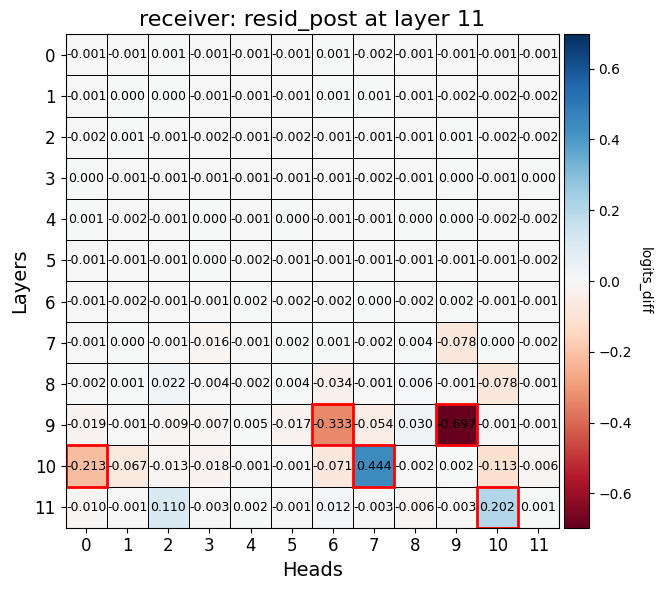

100%|████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 22.93it/s]


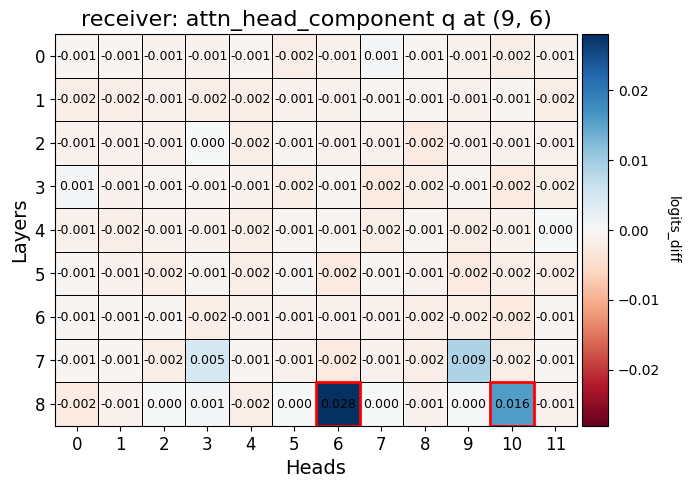

100%|████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 23.12it/s]


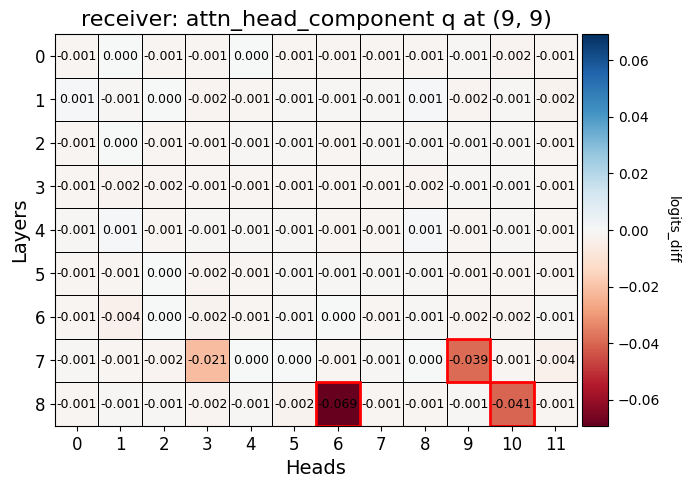

100%|████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 22.91it/s]


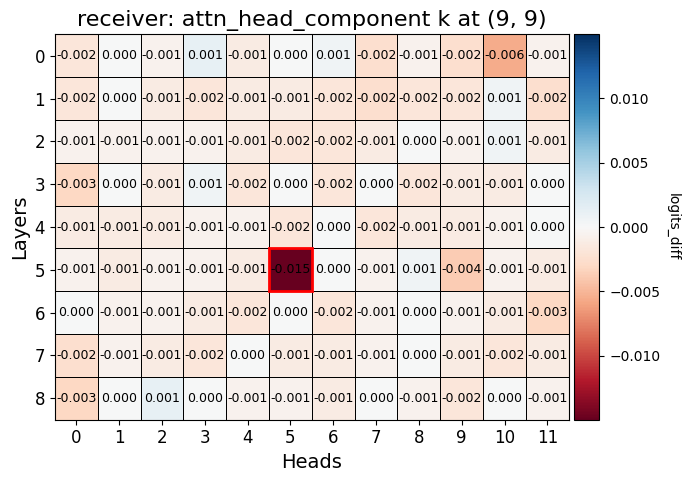

100%|████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.04it/s]


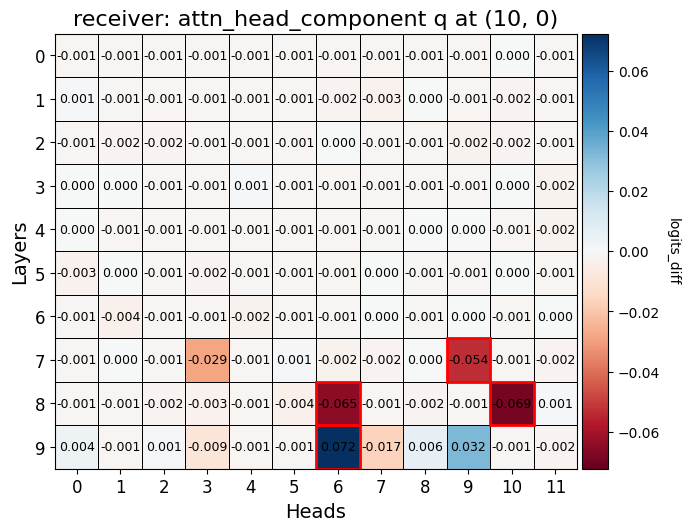

100%|████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 22.75it/s]


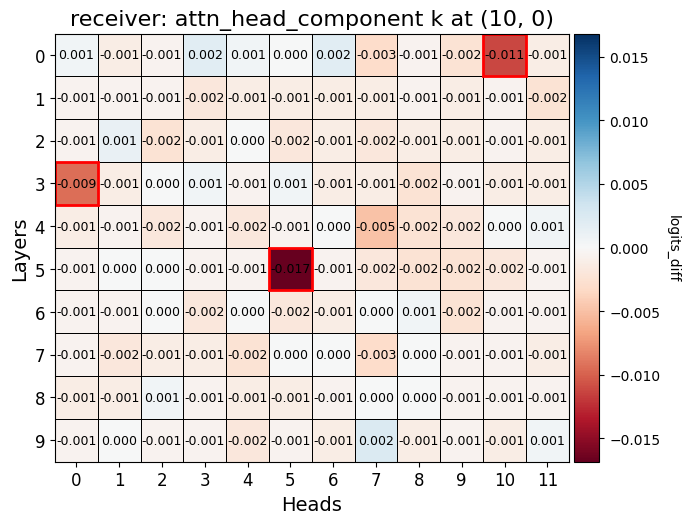

100%|████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [00:05<00:00, 23.06it/s]
 ... (more hidden) ...


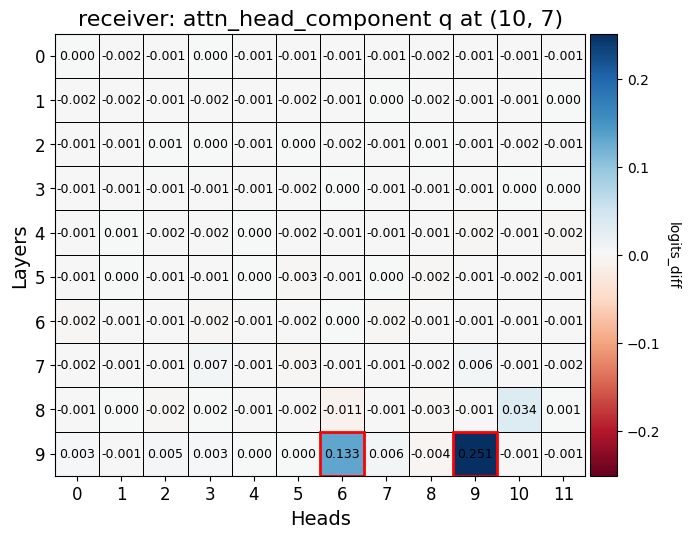

 ... (more hidden) ...


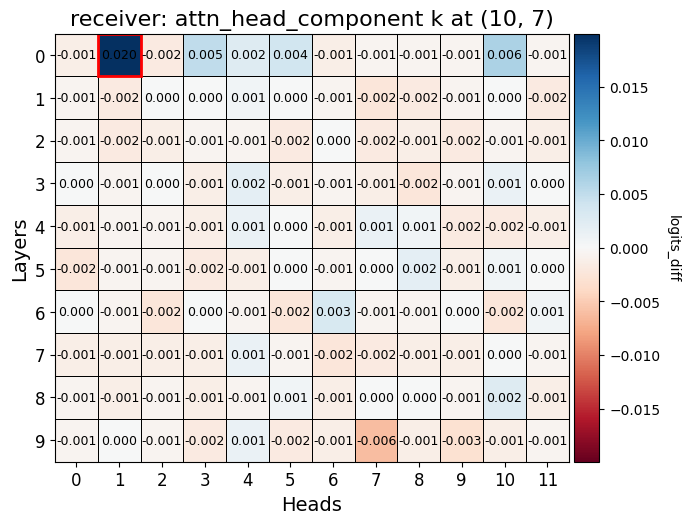

 ... (more hidden) ...


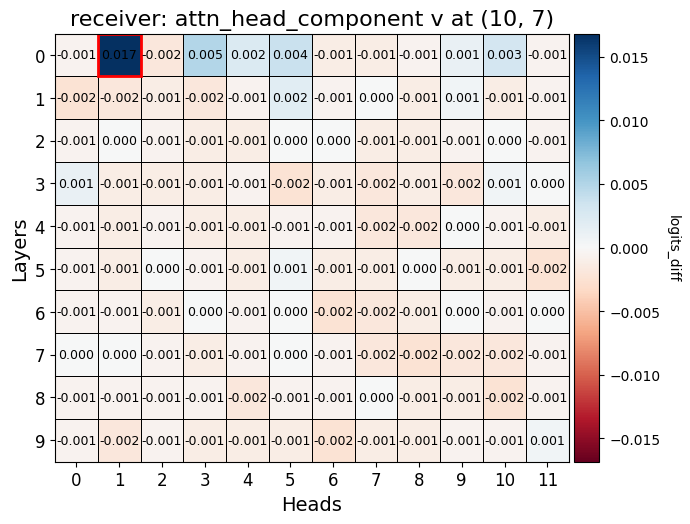

 ... (more hidden) ...


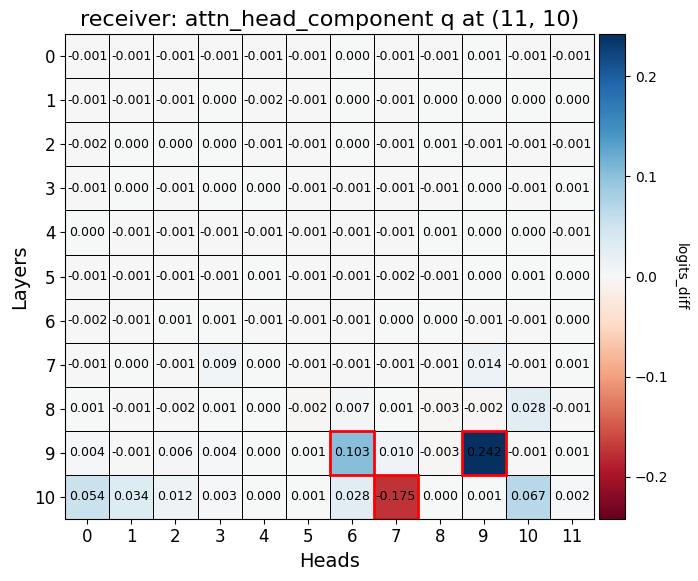

 ... (more hidden) ...


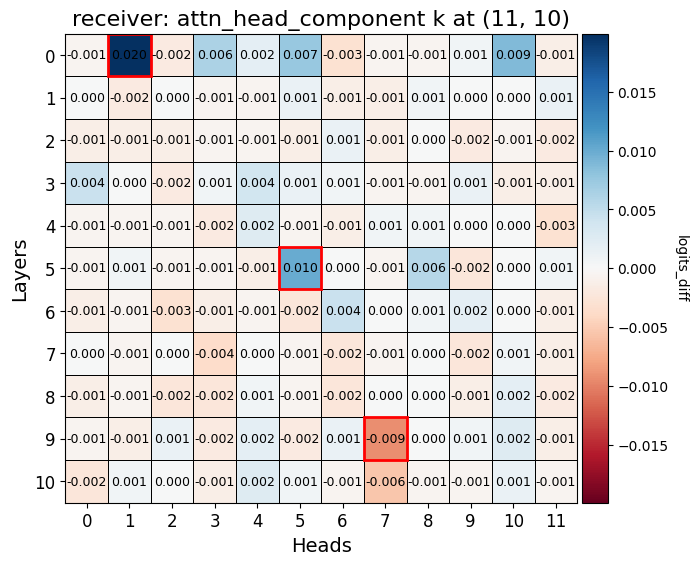

 ... (more hidden) ...
 ... (more hidden) ...


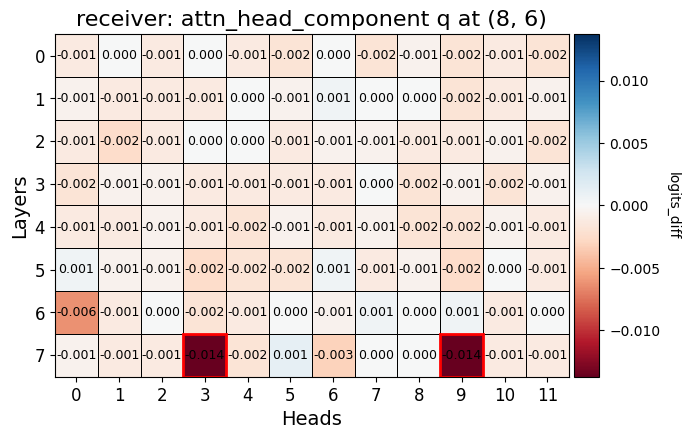

 ... (more hidden) ...


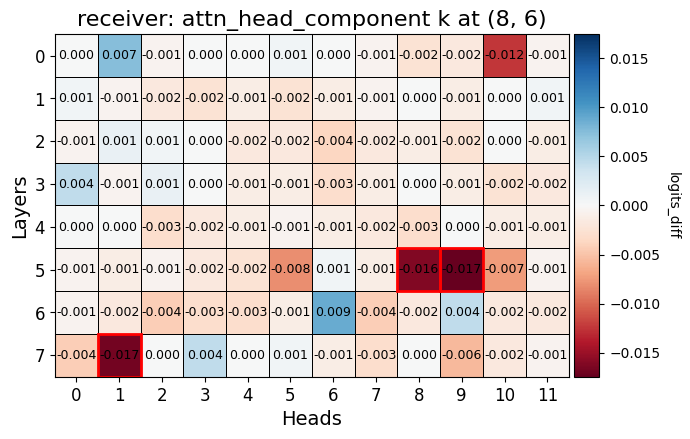

 ... (more hidden) ...


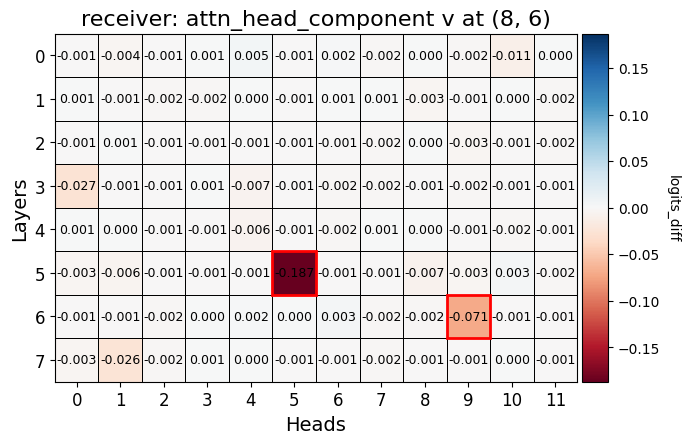

 ... (more hidden) ...


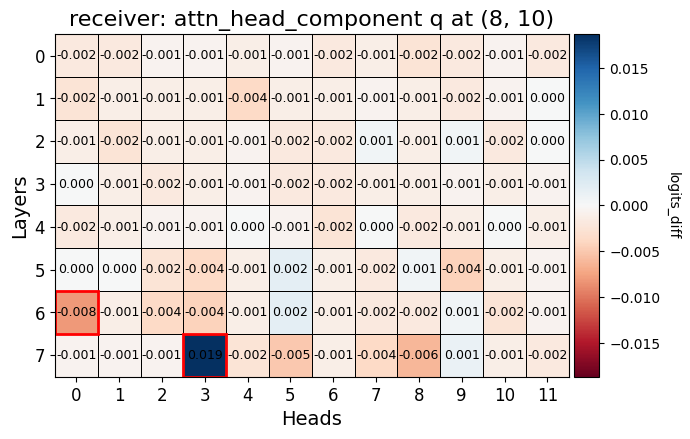

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 22.68it/s]


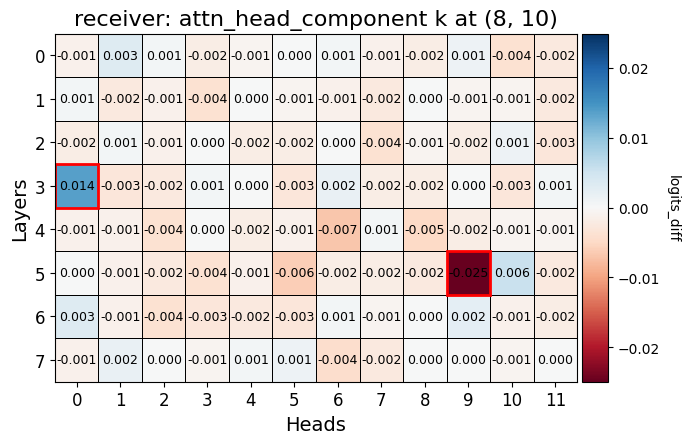

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:04<00:00, 22.99it/s]


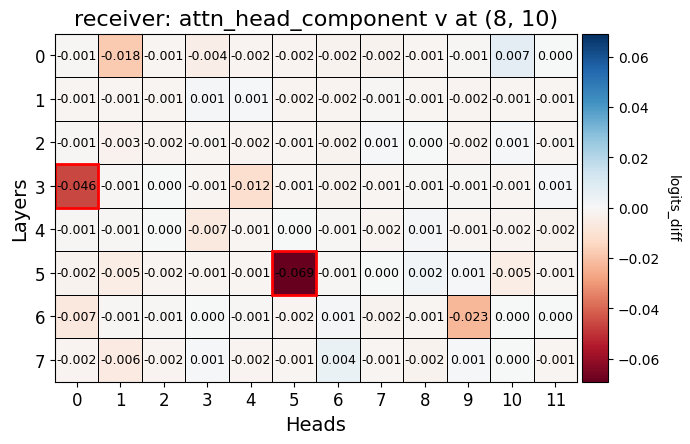

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 23.20it/s]


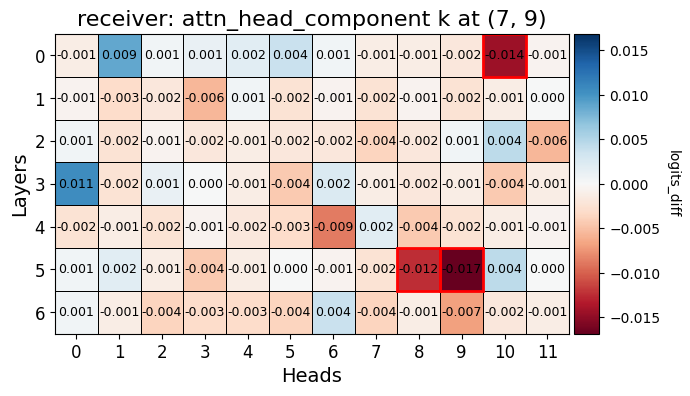

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 23.15it/s]


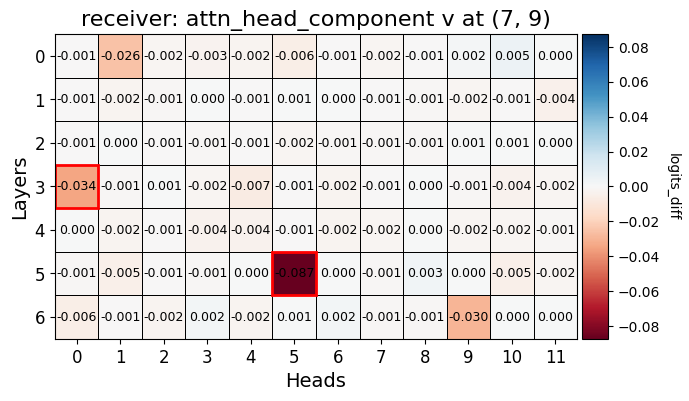

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.02it/s]


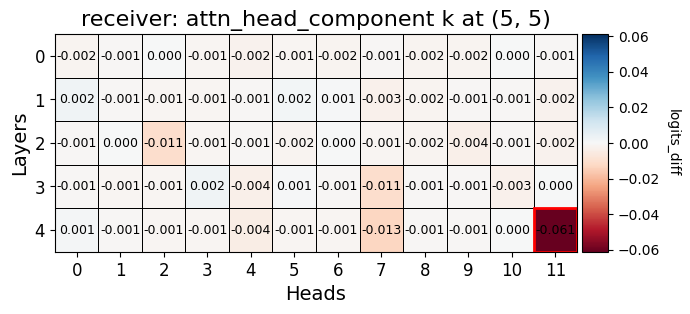

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.91it/s]


skipt zero layers (0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 22.79it/s]


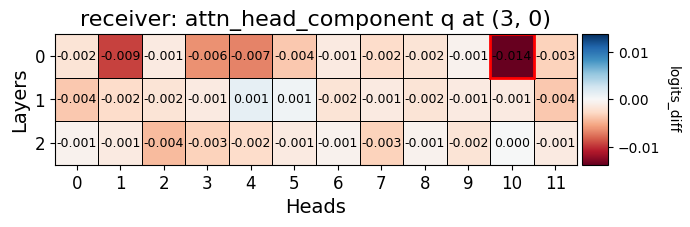

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 22.88it/s]


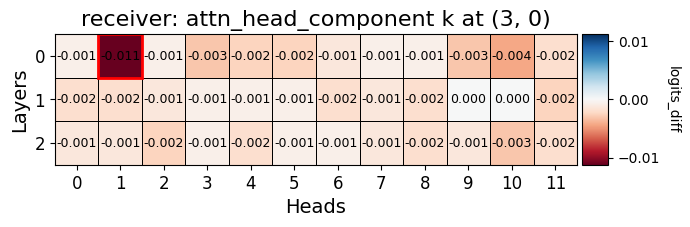

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:01<00:00, 22.89it/s]


skipt zero layers (0, 1)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 22.90it/s]


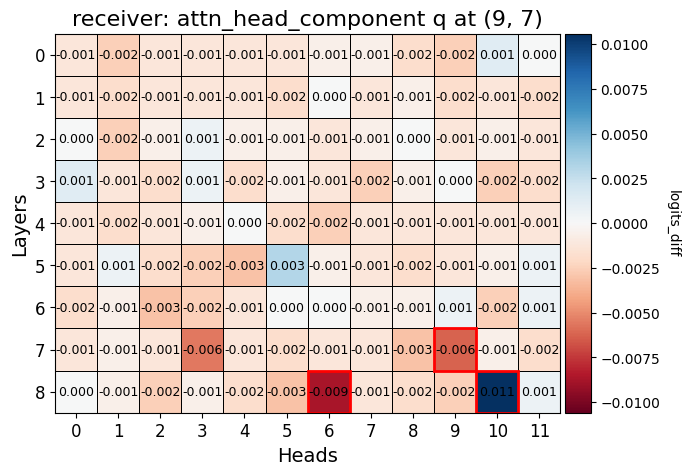

100%|████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:04<00:00, 22.74it/s]


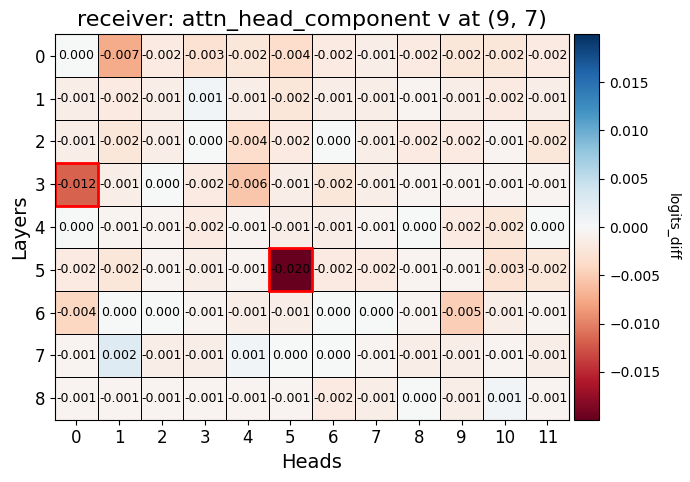

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 22.72it/s]


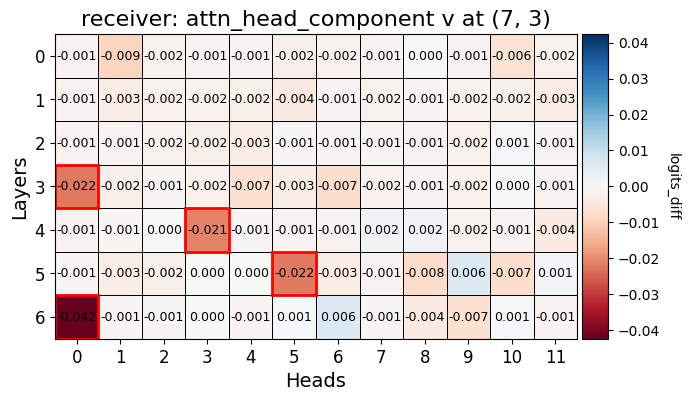

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 23.06it/s]


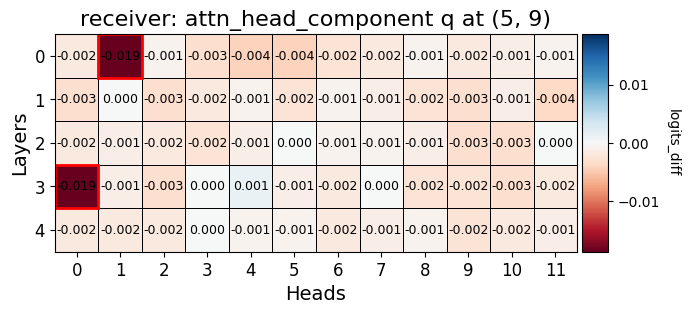

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 84/84 [00:03<00:00, 23.05it/s]


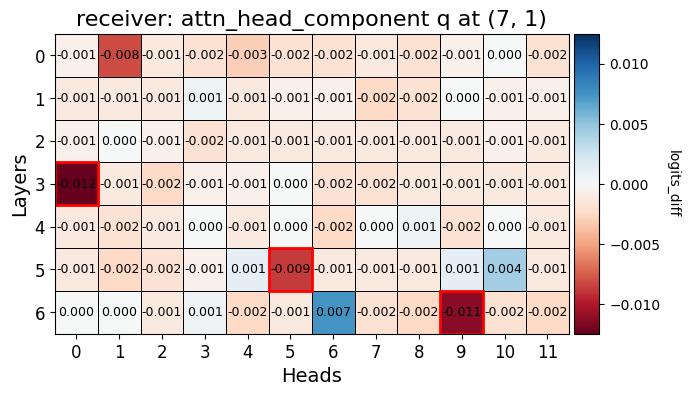

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 23.12it/s]


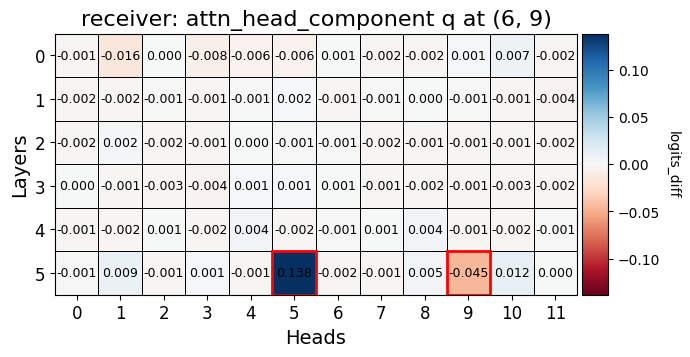

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 23.04it/s]


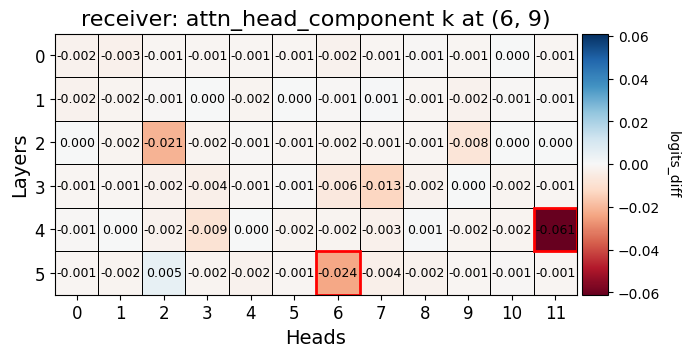

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 72/72 [00:03<00:00, 23.13it/s]


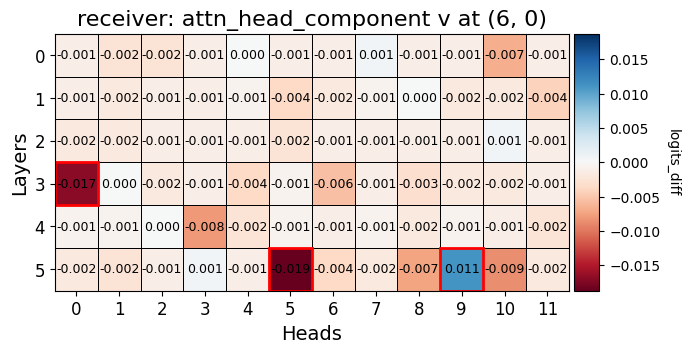

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.02it/s]


skipt zero layers (0, 10)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 23.16it/s]


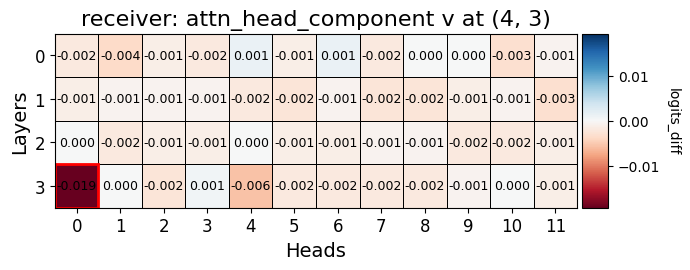

skipt zero layers (0, 1)


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:02<00:00, 22.94it/s]


{9: [6, 9, 7],
 10: [0, 7],
 11: [10],
 8: [6, 10],
 7: [9, 3, 1],
 5: [5, 8, 9, 6],
 0: [10, 1],
 3: [0],
 6: [9, 0],
 4: [11, 3]}

In [4]:
importance_threshold = [2]
min_value_threshold=[0.01]

CIRCUIT = automated_PP(args=args)
CIRCUIT

### Evaluate

In [6]:
eval_size=200
batch_size=40
epochs = int(eval_size/batch_size)
avg_logits = np.zeros(epochs)

#----- Load tokenizer and model ------
eval_tokenizer = load_tokenizer(args.model_name)
model_hooked = load_hooked_transformer(args.model_name, device=args.device, cache_dir=args.cache_dir)

eval_dataset = load_dataset(
    task=args.task, 
    patching_method="path",
    tokenizer=eval_tokenizer, 
    N=eval_size, 
    device=args.device,
    model_name=args.model_name,
    seed=args.seed+100
    )

dataloader = get_dataloader(eval_dataset, batch_size=batch_size, shuffle=False)


# ----- Test that the correct prediction is made -----
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1)

# ----- Average Logit Difference of the unpatched Model -----
for i, batch_dataset in enumerate(dataloader):   
    with t.no_grad():
        logits_gt = model_hooked(batch_dataset["clean_tokens"])
    target_idx = batch_dataset["target_idx"]
    target_idx[:, 0] = target_idx[:, 0] % batch_size
    avg_logits[i] = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=batch_dataset["correct_answers"],
        wrong_answers=batch_dataset["wrong_answers"],
        target_idx=target_idx,
        task=args.task,
        model_name=args.model_name
        )
ave_logit_gt = np.mean(avg_logits)
print("Average logit difference original model: ", ave_logit_gt)


load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
using gpt2 model in IOI dataset
Top 10 Predictions
Prompt 0 : <|endoftext|>Then, Jacob and Mary had a long argument, and afterwards Jacob said to Mary<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
 Mary      | Probability: 0.7100
 his       | Probability: 0.0401
 her       | Probability: 0.0376
 Jacob     | Probability: 0.0243
 them      | Probability: 0.0243
 him       | Probability: 0.0243
 Joseph    | Probability: 0.0167
 the       | Probability: 0.0138
 me        | Probability: 0.0058
 himself   | Probability: 0.0048


Average logit difference original model:  3.575390625


In [7]:

ave_logit, performance = batch_evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name, 
    epochs = epochs, 
    batch_size = batch_size 
    )

print("average logit diff", ave_logit)

result_text = print_statistics(
    title="*********** AUTOMATIC PP CIRCUIT**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)

average logit diff 3.503125

 
*********** AUTOMATIC PP CIRCUIT**************
Average logit difference: 3.5031 
circuit size: 22 
performance achieved: 97.98% 
TPR: 100.00% 
FPR: 0.00% 
Precision: 100.00% 



## Accelerated Path Patching

loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
load gpt2 tokenizer
using gpt2 model in IOI dataset
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7f1b7c1382d0>


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.1.hook_q_input, blocks.1.hook_resid_mid, blocks.1.hook_resid_post, blocks.1.hook_resid_pre, blocks.1.hook_v_input, blocks.1.ln1.hook_n

result gpt2/ioi/APP_hybrid/min_threshold-0.01/scale-2


 ... (more hidden) ...


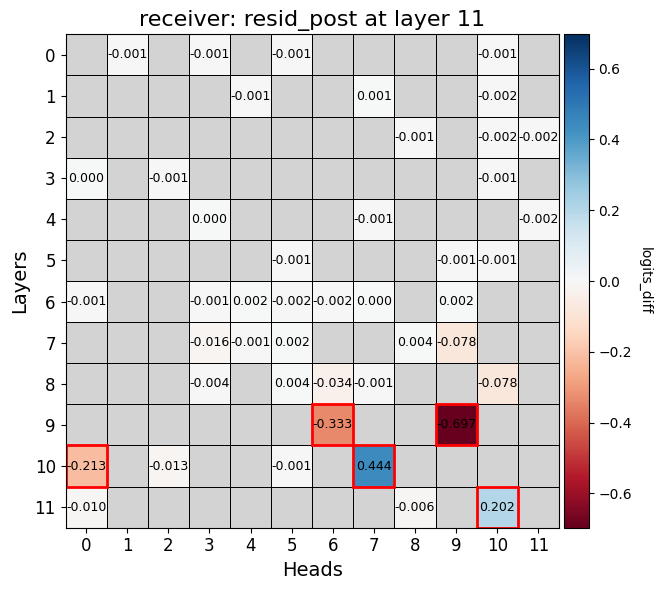

 ... (more hidden) ...


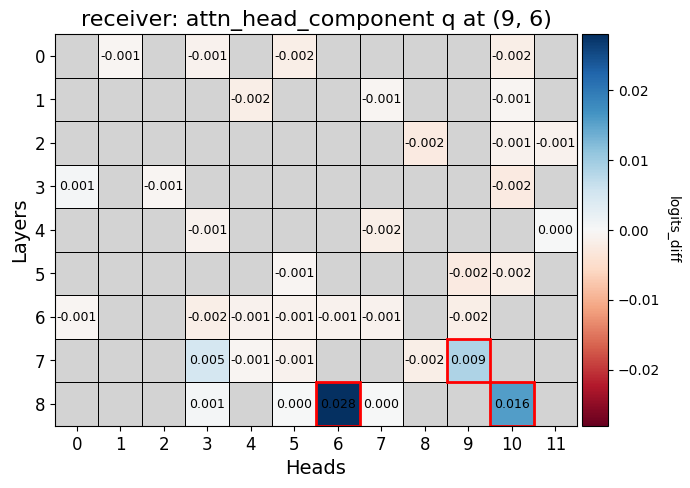

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


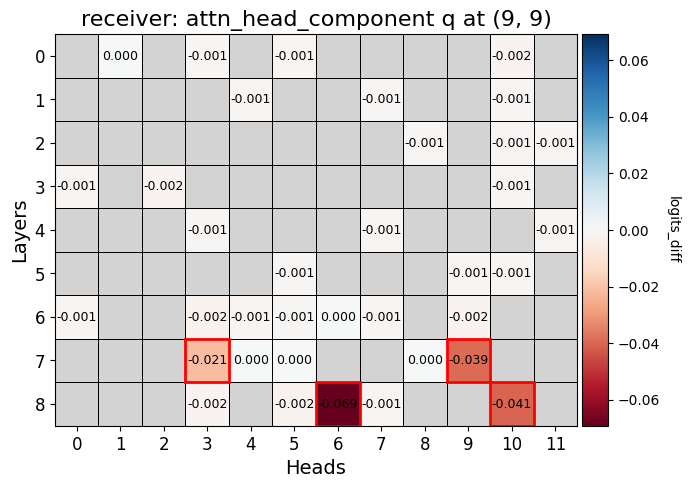

 ... (more hidden) ...


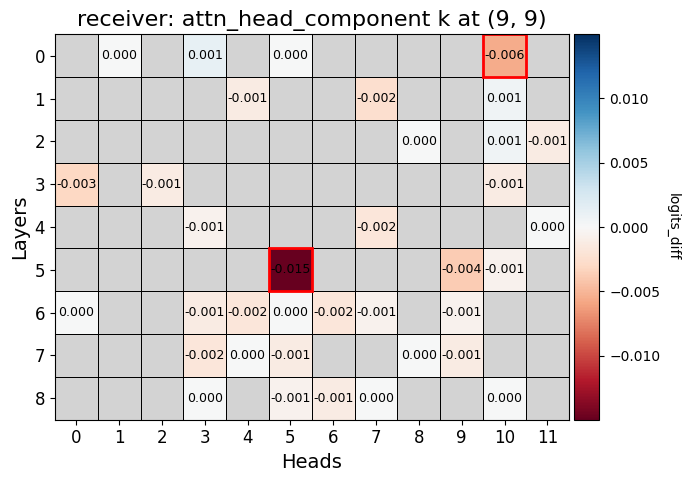

 ... (more hidden) ...
 ... (more hidden) ...


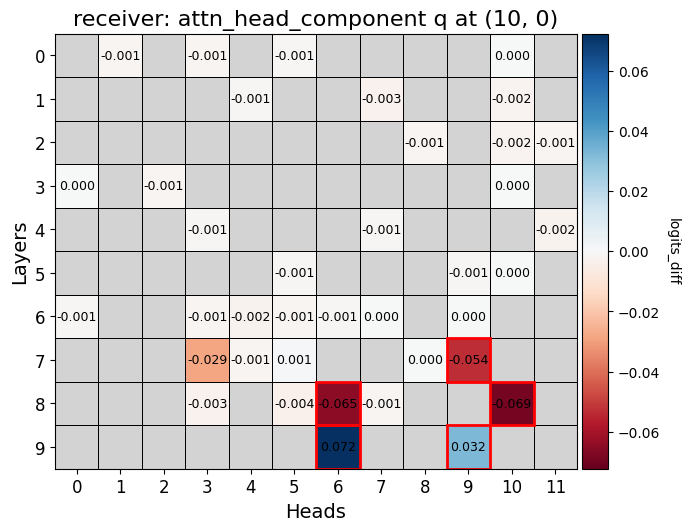

 ... (more hidden) ...


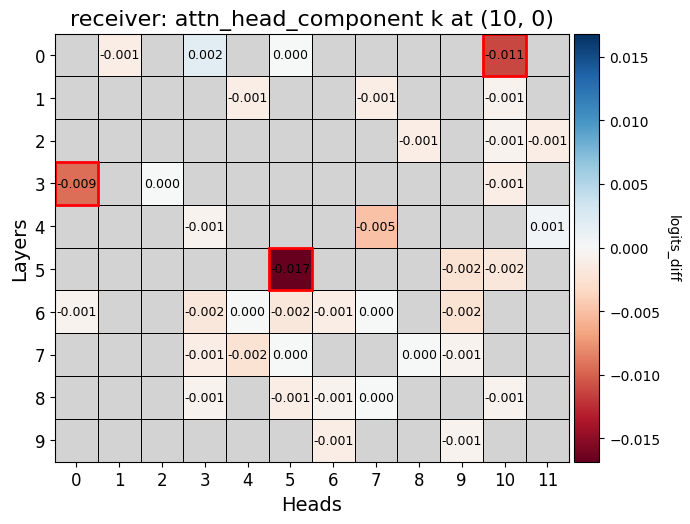

 ... (more hidden) ...
 ... (more hidden) ...


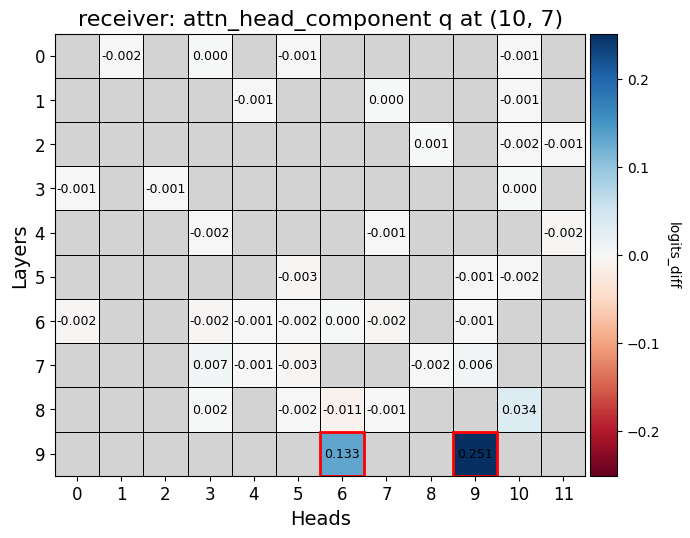

 ... (more hidden) ...


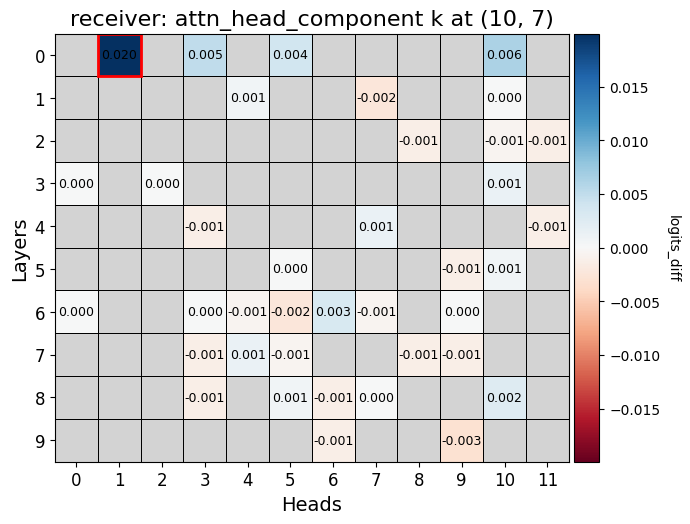

 ... (more hidden) ...


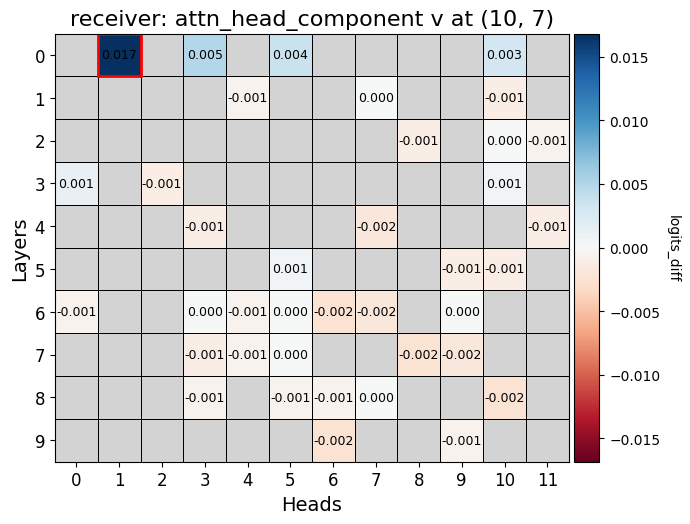

 ... (more hidden) ...


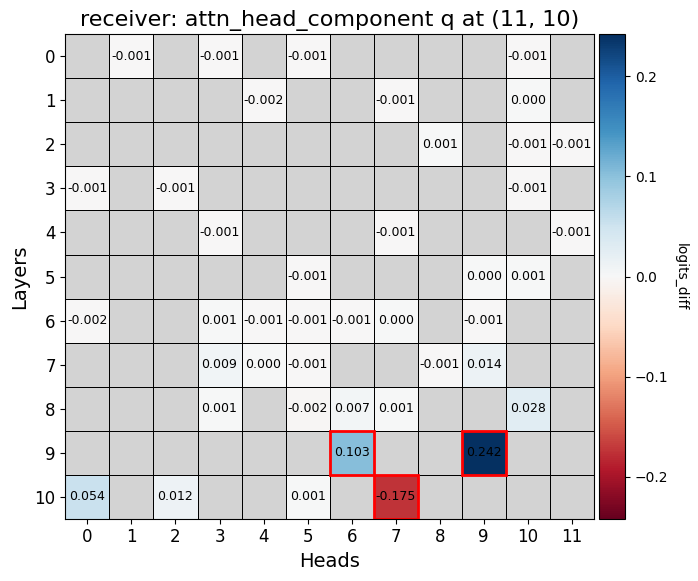

 ... (more hidden) ...


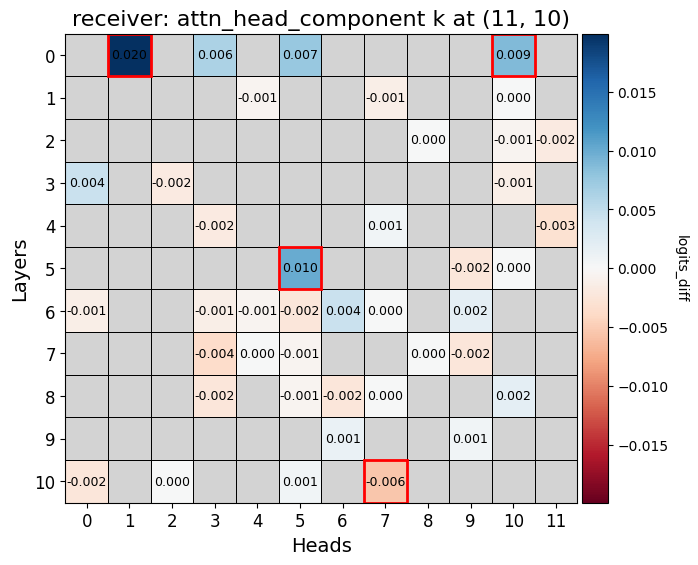

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


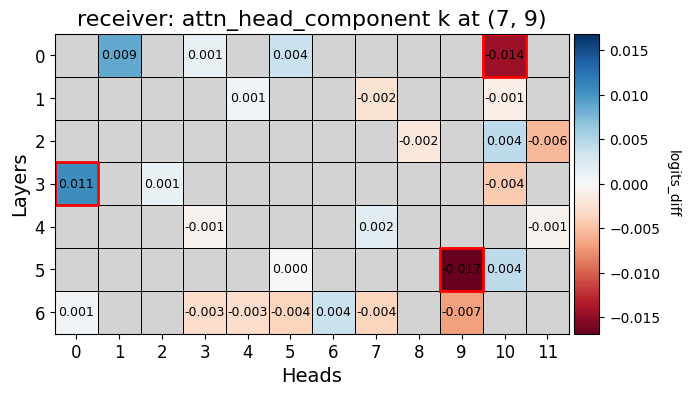

 ... (more hidden) ...


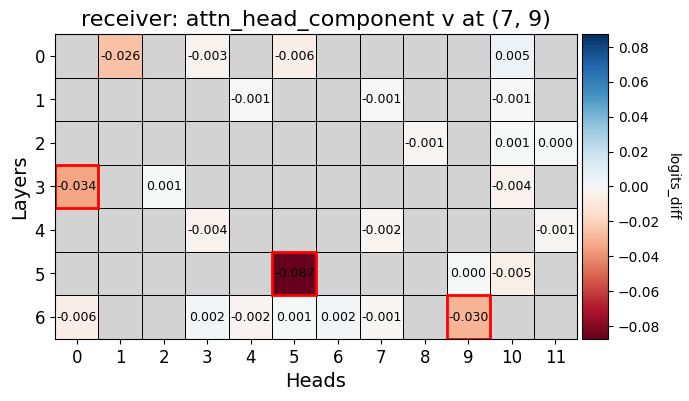

 ... (more hidden) ...


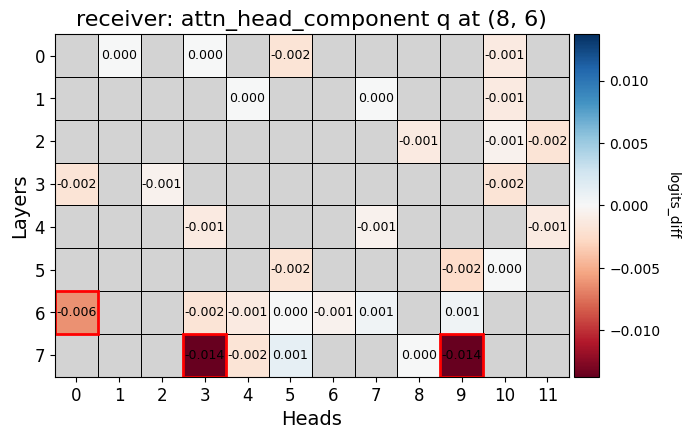

 ... (more hidden) ...


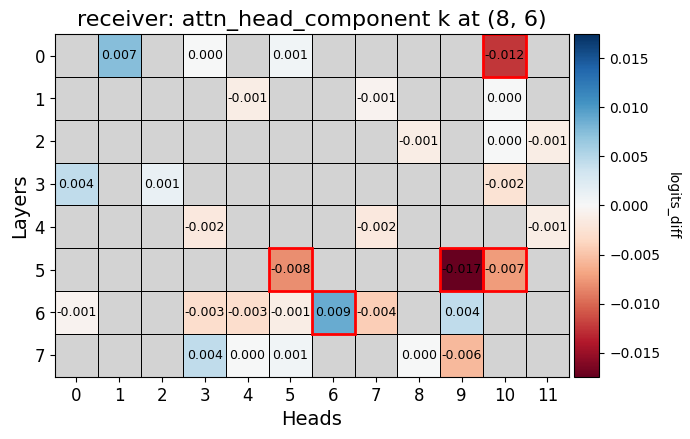

 ... (more hidden) ...


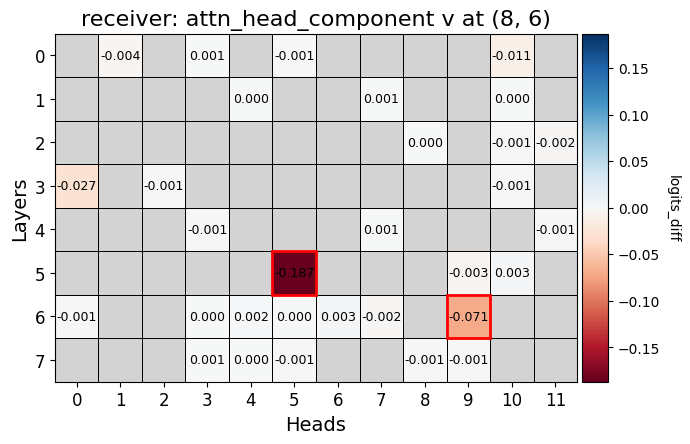

 ... (more hidden) ...


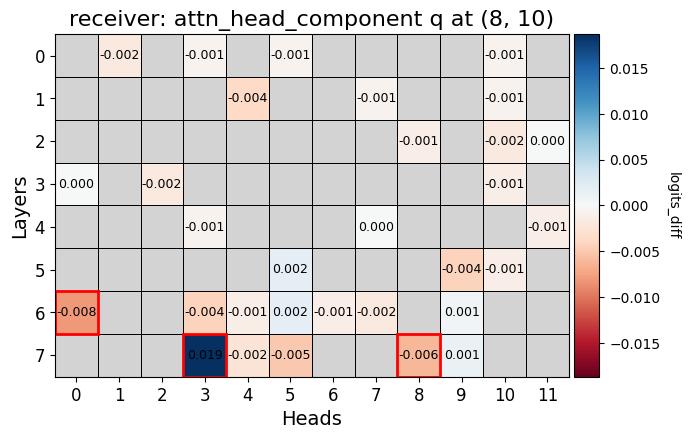

 ... (more hidden) ...


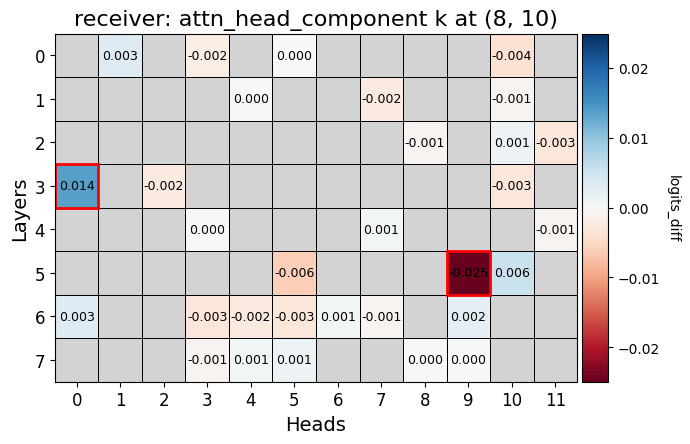

 ... (more hidden) ...


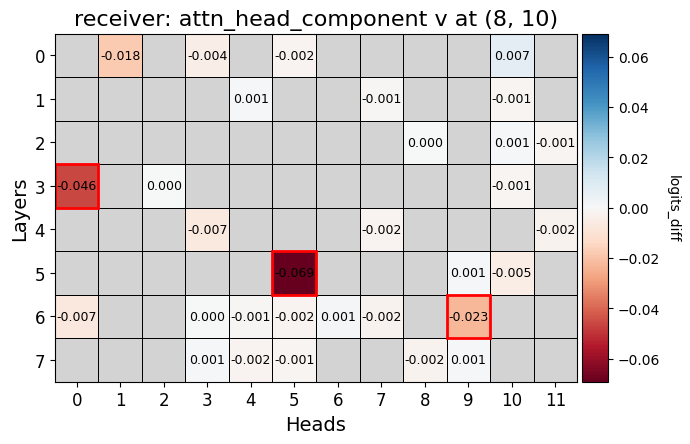

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


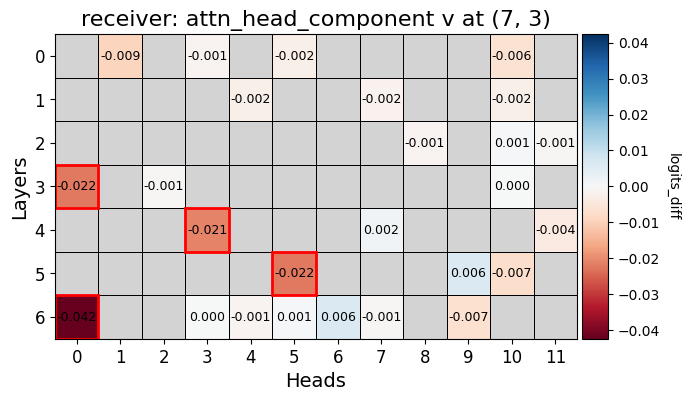

skipt zero layers (0, 10)


 ... (more hidden) ...
 ... (more hidden) ...


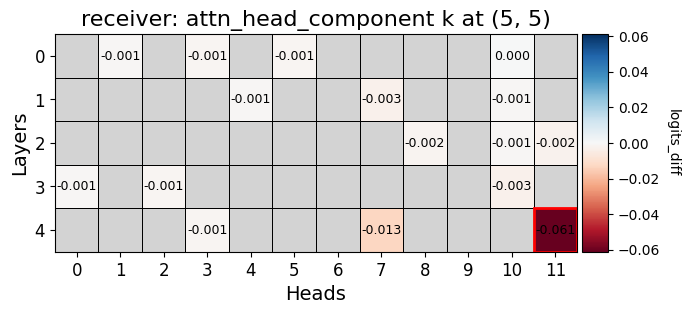

 ... (more hidden) ...
 ... (more hidden) ...


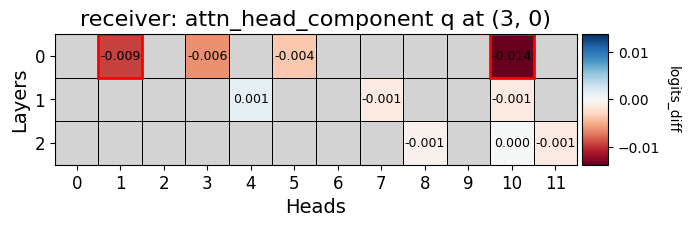

 ... (more hidden) ...


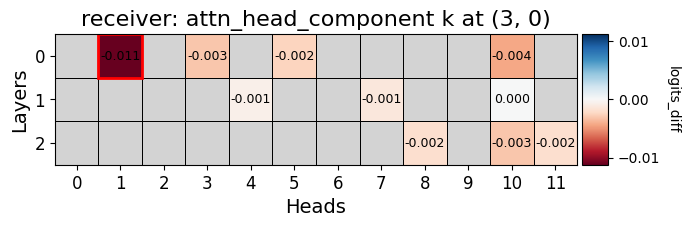

 ... (more hidden) ...


skipt zero layers (0, 1)


 ... (more hidden) ...


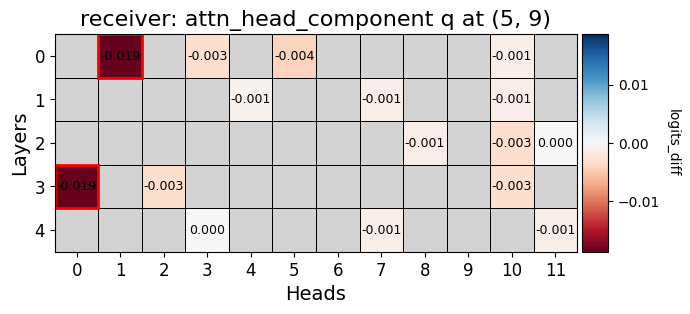

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


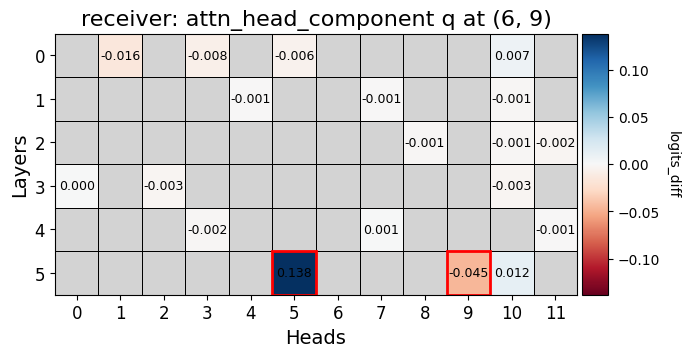

 ... (more hidden) ...


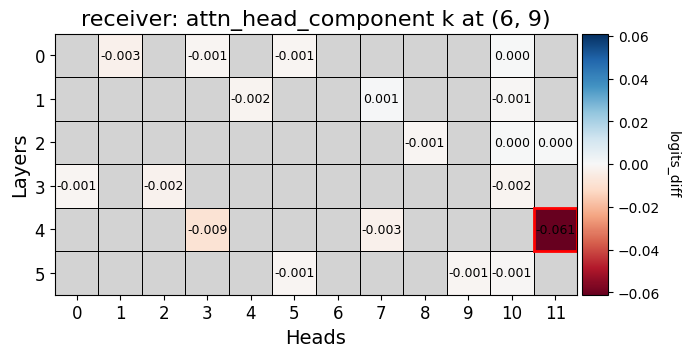

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


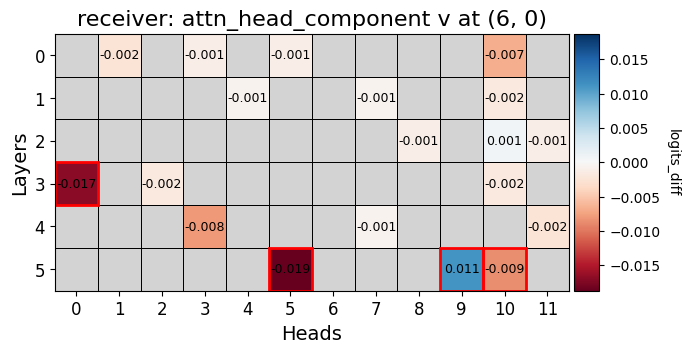

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


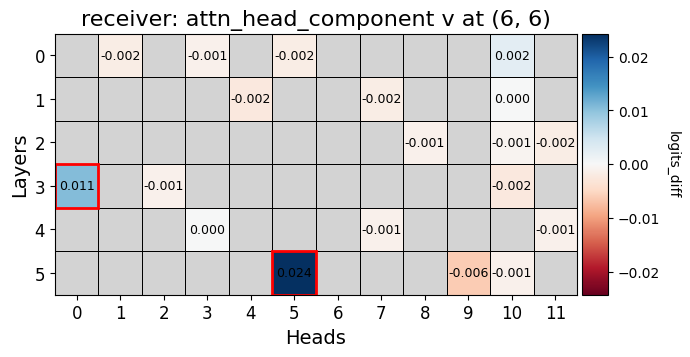

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


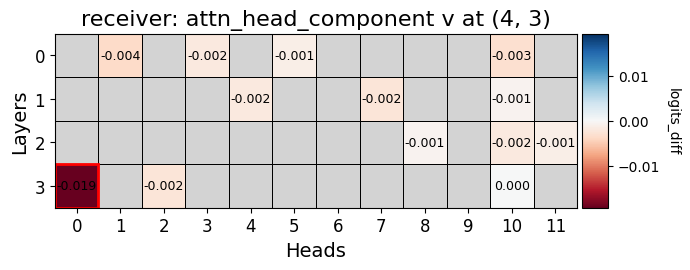

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...

skipt zero layers (0, 10)
skipt zero layers (0, 1)


{9: [6, 9],
 10: [0, 7],
 11: [10],
 7: [9, 3, 8],
 8: [6, 10],
 0: [10, 1],
 5: [5, 9, 10],
 3: [0],
 6: [9, 0, 6],
 4: [3, 11]}

In [6]:
gc.collect()
t.cuda.empty_cache()

args.pruning_circuit = "hybrid"
scales = [2]
min_activation_thresholds=[0.01]

CIRCUIT = automated_PP(     
    args=args,
    scales = scales,
    min_activation_thresholds=min_activation_thresholds,
    resid_scale=2
    )
CIRCUIT

### Evaluate

In [ ]:

#----- Load tokenizer and model ------
eval_tokenizer = load_tokenizer(args.model_name)
model_hooked = load_hooked_transformer(args.model_name, device=args.device, cache_dir=args.cache_dir)
eval_dataset = load_dataset(
    prepend_bos=args.prepend_bos,
    task=args.task, 
    patching_method="path",
    tokenizer=eval_tokenizer, 
    N=200, 
    device=args.device,
    model_name=args.model_name,
    seed=args.seed+20
    )


# ----- Test that the correct prediction is made -----
predict_target_token(model_hooked, eval_dataset, eval_tokenizer, device=args.device, n=1)

# ----- Average Logit Difference of the unpatched Model -----
for i, batch_dataset in enumerate(dataloader):   
    with t.no_grad():
        logits_gt = model_hooked(batch_dataset["clean_tokens"])
    target_idx = batch_dataset["target_idx"]
    target_idx[:, 0] = target_idx[:, 0] % batch_size
    avg_logits[i] = ave_logit_diff(
        logits=logits_gt, 
        correct_answers=batch_dataset["correct_answers"],
        wrong_answers=batch_dataset["wrong_answers"],
        target_idx=target_idx,
        task=args.task,
        model_name=args.model_name
        )
ave_logit_gt = np.mean(avg_logits)
print("Average logit difference original model: ", ave_logit_gt)



load gpt2 tokenizer
loading gpt2 as HookedTransformer
use float 16
Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda
Load GreaterThan with gpt2
Top 10 Predictions
Prompt 0 : The test lasted from the year 1615 to the year 1676
20         | Probability: 0.1610
60         | Probability: 0.0671
30         | Probability: 0.0671
18         | Probability: 0.0522
50         | Probability: 0.0522
40         | Probability: 0.0461
25         | Probability: 0.0317
16         | Probability: 0.0280
19         | Probability: 0.0247
17         | Probability: 0.0247


Average logit difference original model:  3.3418750762939453


In [21]:
ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name
    )

result_text = print_statics(
    title=f"*********** PP circuit for {args.task} on model {args.model_name}**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)


 
*********** PP circuit for GreaterThan on model gpt2**************
Average logit difference: 2.6363 
circuit size: 8 
performance achieved: 78.89% 
TPR: 100.00% 
FPR: 0.00% 
Precision: 100.00% 



In [22]:

ave_logit, performance = evaluate_circiut(
    model = model_hooked, 
    CIRCUIT=APP_CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt,
    task=args.task,
    model_name=args.model_name
    )

result_text = print_statics(
    title=f"*********** APP circuit for {args.task} on model {args.model_name}**************",
    ave_logit=ave_logit, 
    performance_achieved=performance,
    CIRCUIT=APP_CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )
 
print(result_text)


 
*********** APP circuit for GreaterThan on model gpt2**************
Average logit difference: 2.1637 
circuit size: 7 
performance achieved: 64.75% 
TPR: 75.00% 
FPR: 14.29% 
Precision: 85.71% 



In [102]:
from circuits.circuits_FLAP import CIRCUIT
CIRCUIT

{0: {1, 3, 5, 10},
 1: {4, 7, 10},
 2: {8, 10, 11},
 3: {0, 2, 10},
 4: {3, 7, 11},
 5: {5, 9, 10},
 6: {0, 3, 4, 5, 6, 7, 9},
 7: {3, 4, 5, 8, 9},
 8: {3, 5, 6, 7, 10},
 9: {6, 9},
 10: {0, 2, 5, 7},
 11: {0, 8, 10}}

## Contrastive APP

Namespace(model_name='Qwen/Qwen2.5-0.5B', task='GreaterThan', metric='logits_diff', cache_dir='/mnt/lustre/work/eickhoff/esx670/llm_weights', out_path='/mnt/lustre/work/eickhoff/esx670/res_final/', device='cuda', N=100, prepend_bos=False, seed=12345432, per_position=False, patch_mlp=False, patching_method='path', alpha=0.5, mode='sqrt', scale=1.5, k=2, use_old_input=False, save_every_x_steps=100, min_activation_threshold=0.002, show=True, save_img=False, save_text=False, verbose=False, calc_FLOPS=True, threshold=0.35, zero_ablation=False, remove_redundant=False, reset_network=False, online_cache_cpu=False, corrupted_cache_cpu=False, abs_value_threshold=False)


load Qwen tokenizer
loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
Top 10 Predictions
Prompt 0 : The test lasted from the year 1615 to the year 1672
1          | Probability: 0.3105
2          | Probability: 0.2345
3          | Probability: 0.1400
4          | Probability: 0.0836
6          | Probability: 0.0641
5          | Probability: 0.0631
7          | Probability: 0.0469
8          | Probability: 0.0333
9          | Probability: 0.0215
0          | Probability: 0.0010


loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
FLOP per forwad <fvcore.nn.flop_count.FlopCountAnalysis object at 0x7f82c071c810>


blocks.0.attn.hook_attn_scores, blocks.0.attn.hook_k, blocks.0.attn.hook_pattern, blocks.0.attn.hook_q, blocks.0.attn.hook_result, blocks.0.attn.hook_rot_k, blocks.0.attn.hook_rot_q, blocks.0.attn.hook_v, blocks.0.attn.hook_z, blocks.0.hook_attn_in, blocks.0.hook_attn_out, blocks.0.hook_k_input, blocks.0.hook_mlp_in, blocks.0.hook_mlp_out, blocks.0.hook_q_input, blocks.0.hook_resid_mid, blocks.0.hook_resid_post, blocks.0.hook_resid_pre, blocks.0.hook_v_input, blocks.0.ln1.hook_normalized, blocks.0.ln1.hook_scale, blocks.0.ln2.hook_normalized, blocks.0.ln2.hook_scale, blocks.0.mlp.hook_post, blocks.0.mlp.hook_pre, blocks.0.mlp.hook_pre_linear, blocks.1.attn.hook_attn_scores, blocks.1.attn.hook_k, blocks.1.attn.hook_pattern, blocks.1.attn.hook_q, blocks.1.attn.hook_result, blocks.1.attn.hook_rot_k, blocks.1.attn.hook_rot_q, blocks.1.attn.hook_v, blocks.1.attn.hook_z, blocks.1.hook_attn_in, blocks.1.hook_attn_out, blocks.1.hook_k_input, blocks.1.hook_mlp_in, blocks.1.hook_mlp_out, blocks.

Average logit difference original model:  4.048047065734863
result Qwen/Qwen2.5-0.5B/GreaterThan/contr_APP/min_threshold-0.002/scale_1.75
create new path /mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-0.5B/GreaterThan/contr_APP/min_threshold-0.002/scale_1.75


 ... (more hidden) ...


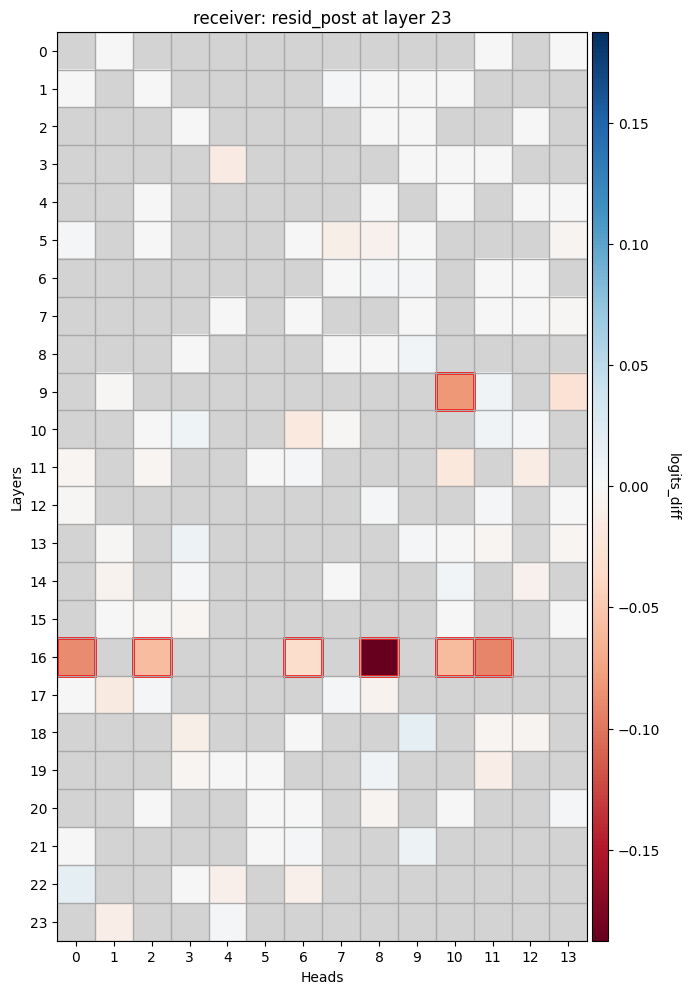

 ... (more hidden) ...
 ... (more hidden) ...


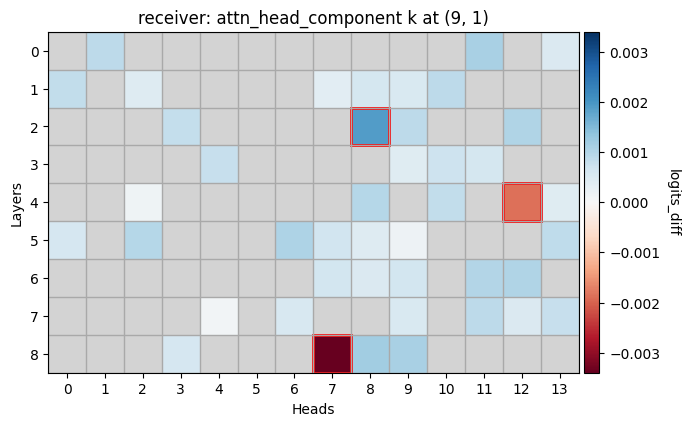

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


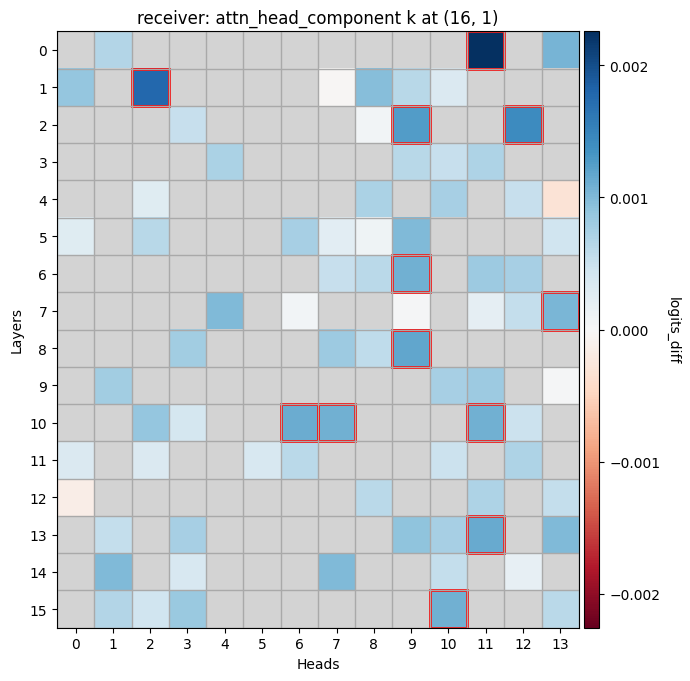

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


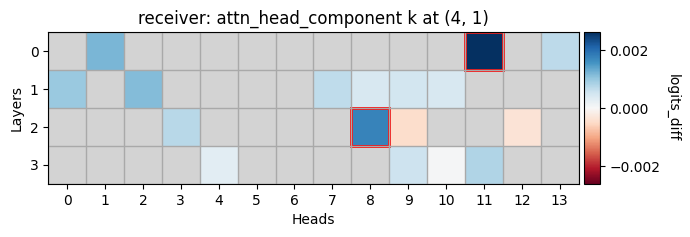

 ... (more hidden) ...
 ... (more hidden) ...


skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


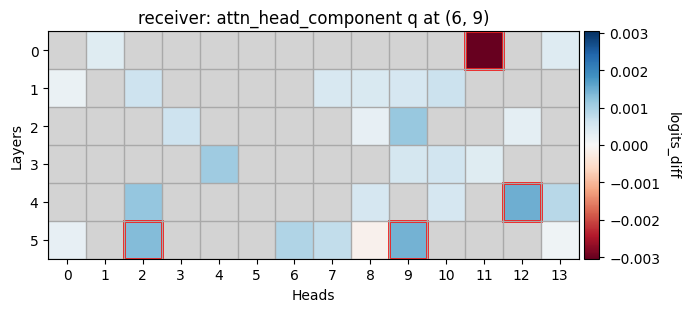

 ... (more hidden) ...


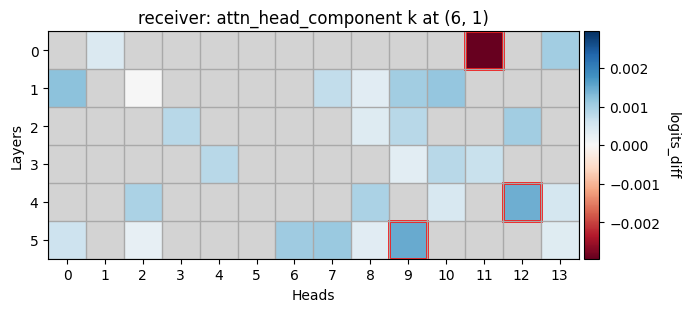

 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


skipt zero layers (0, 11)


 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...
 ... (more hidden) ...


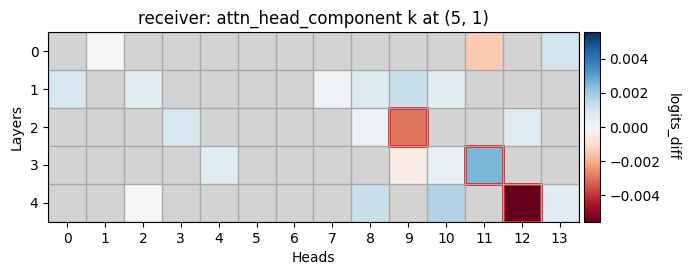

 ... (more hidden) ...
 ... (more hidden) ...


{9: [10],
 16: [0, 2, 6, 8, 10, 11],
 2: [8, 9, 12],
 4: [12],
 8: [7, 9],
 0: [11],
 1: [2],
 6: [9],
 7: [13],
 10: [6, 7, 11],
 13: [11],
 15: [10],
 5: [2, 9],
 3: [11]}

In [14]:
from Patching.contr_APP import contr_APP
gc.collect()
t.cuda.empty_cache()

#scales = [2.5, 2, 1.5, 1]
scales=[1.75]
min_activation_thresholds=[0.002]
ks = [2]
#scales = [2]

APP_CIRCUIT = contr_APP(     
    args=args,
    ks = ks, 
    scales = scales,
    min_activation_thresholds=min_activation_thresholds, 
    resid_scale=2
)
APP_CIRCUIT


In [12]:
APP_CIRCUIT

{9: [10, 11, 13, 1],
 16: [0, 2, 6, 8, 10, 11],
 2: [8, 9, 12],
 4: [12, 2, 10, 13],
 8: [7, 8, 9, 3],
 0: [11, 1],
 1: [2, 0, 9, 10, 7],
 5: [9, 2, 7, 8, 13],
 6: [9, 12, 8],
 7: [4, 13, 6, 12, 9],
 10: [6, 7, 11, 3, 12],
 13: [9, 11, 13, 10],
 14: [1, 7],
 15: [10],
 3: [11, 10, 9],
 12: [0, 11],
 11: [0, 12, 2, 5]}

## Load And Evalaute A Circuit

In [80]:
#CIRCUIT = load_circuit(subfolder, name="circuit.txt")

CIRCUIT = load_circuit("/mnt/lustre/work/eickhoff/esx670/res_final/Qwen/Qwen2.5-7B/induction/FLAP_Path_Patching/logits_diff/sqrt/min_threshold-0.0001/k_2-scale_2.5/", name= "circuit.txt")
CIRCUIT = dict(sorted(CIRCUIT.items()))
CIRCUIT_size = circuit_size(CIRCUIT=CIRCUIT)
CIRCUIT

{0: [3, 10], 21: [17], 22: [25], 23: [11, 13], 26: [22], 27: [10, 13]}

In [81]:
#CIRCUIT = load_circuit(subfolder, name="circuit.txt")

CIRCUIT = load_circuit("/mnt/lustre/work/eickhoff/esx670/res/Qwen/Qwen2.5-0.5B/ioi/path/automatic/logits_diff/sqrt/min_threshold-0.02/k_2-scale_1.5/", name= "circuit.txt")
CIRCUIT = dict(sorted(CIRCUIT.items()))
CIRCUIT_size = circuit_size(CIRCUIT=CIRCUIT)
CIRCUIT


{0: [1],
 3: [4],
 4: [12],
 5: [9],
 6: [9],
 8: [7],
 9: [13, 10],
 10: [6],
 11: [10, 12, 8],
 12: [0, 10, 11, 13, 7],
 13: [2, 3, 6, 10],
 14: [0, 3, 5, 1, 2],
 15: [7, 10, 0, 6, 13, 5],
 16: [10, 7],
 19: [6, 8, 10, 11, 4, 9],
 20: [7, 9, 12],
 21: [0, 12, 9, 1, 11, 6],
 22: [0, 6, 11, 9, 13],
 23: [2, 12]}

In [17]:
hooked_model = load_hooked_transformer(args.model_name, args.device,cache_dir=args.cache_dir)
tokenizer = load_tokenizer(args.model_name)
eval_dataset = load_dataset(
    prepend_bos=args.prepend_bos, 
    task=args.task, 
    patching_method="path",
    tokenizer=tokenizer, 
    N=200,
    device=args.device, 
    model_name=args.model_name,
    seed=args.seed+20
    )

hooked_model.reset_hooks(including_permanent=True)

with torch.no_grad():
    hooked_gt = hooked_model(eval_dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(
    logits=hooked_gt, 
    correct_answers=eval_dataset.correct_answers,
    wrong_answers=eval_dataset.wrong_answers,    target_idx=eval_dataset.target_idx.to(args.device),
    task=args.task,
    model_name=args.model_name
    )

print("average logit ground truth", ave_logit_gt, "\n")

#print(f"circuit size {CIRCUIT_size}/{hooked_model.cfg.n_layers * hooked_model.cfg.n_heads}")

ave_logit_circuit, performance = evaluate_circiut(
            model=hooked_model, 
            CIRCUIT=APP_CIRCUIT,
            dataset=eval_dataset,
            ave_logit_gt=ave_logit_gt, 
            task=args.task,
            model_name=args.model_name
        )

result_text = print_statics(
    title="*********** IOI CIRCUIT FOUND BY ACCELERATED PATH PATCHING **************",
    ave_logit=ave_logit_circuit, 
    performance_achieved=performance,
    CIRCUIT=APP_CIRCUIT, 
    IOI_CIRCUIT=CIRCUIT
    )

print(result_text)

loading Qwen/Qwen2.5-0.5B as HookedTransformer
use float 16
Loaded pretrained model Qwen/Qwen2.5-0.5B into HookedTransformer
Moving model to device:  cuda
load Qwen tokenizer
loading GreaterThan dataset for Qwen/Qwen2.5-0.5B
average logit ground truth 4.250468730926514 


 
*********** IOI CIRCUIT FOUND BY ACCELERATED PATH PATCHING **************
Average logit difference: 2.8406 
circuit size: 21 
performance achieved: 66.83% 
TPR: 80.00% 
FPR: 23.81% 
Precision: 76.19% 



In [ ]:
model_mean_ablation = pp._model
model_mean_ablation.reset_hooks(including_permanent=True)
tokenizer = model_mean_ablation.tokenizer
model_mean_ablation.eval()

eval_dataset = load_dataset(prepend_bos=False, task=args.task, patching_method="path",tokenizer=tokenizer, N=20   , device=args.device)

# original gpt2 model
logits_gt = model_mean_ablation(eval_dataset.clean_tokens)
ave_logit_gt = ave_logit_diff(logits_gt, eval_dataset.answer_tokens, eval_dataset.target_idx.to(args.device))

ave_logit_circuit, performance_cicrcuit = evaluate_circiut(
    model = model_mean_ablation, 
    CIRCUIT=CIRCUIT,
    dataset=eval_dataset,
    ave_logit_gt=ave_logit_gt
    )


# Look at Attention Pattern

In [274]:
from circuits import IOI_CIRCUIT
CIRCUIT = IOI_CIRCUIT

CIRCUIT = {11: [1, 8], 
           10: [9],
           9: [7], 
           6: [0], 
           4: [3], 
           2: [6], 
           1: [4], 
           0: [4]
           
           }


The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['output_attentions']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


load gpt2 tokenizer
load gpt2 as CasualLLM
loading GenderedPronouns dataset for gpt2
Top 10 Predictions
Prompt 0 : That Person is really clever, isnt't she
 he        | Probability: 0.6005
 she       | Probability: 0.0701
 it        | Probability: 0.0689
 that      | Probability: 0.0688
 this      | Probability: 0.0223
 his       | Probability: 0.0167
 there     | Probability: 0.0162
 the       | Probability: 0.0096
 He        | Probability: 0.0078
 they      | Probability: 0.0074


Top 10 Predictions
Prompt 0 : So Anna is really clever, isnt't she
 she       | Probability: 0.8612
 it        | Probability: 0.0693
 that      | Probability: 0.0129
 her       | Probability: 0.0115
 there     | Probability: 0.0098
 he        | Probability: 0.0082
 this      | Probability: 0.0039
 the       | Probability: 0.0016
 She       | Probability: 0.0013
.          | Probability: 0.0008


from 0 to 10


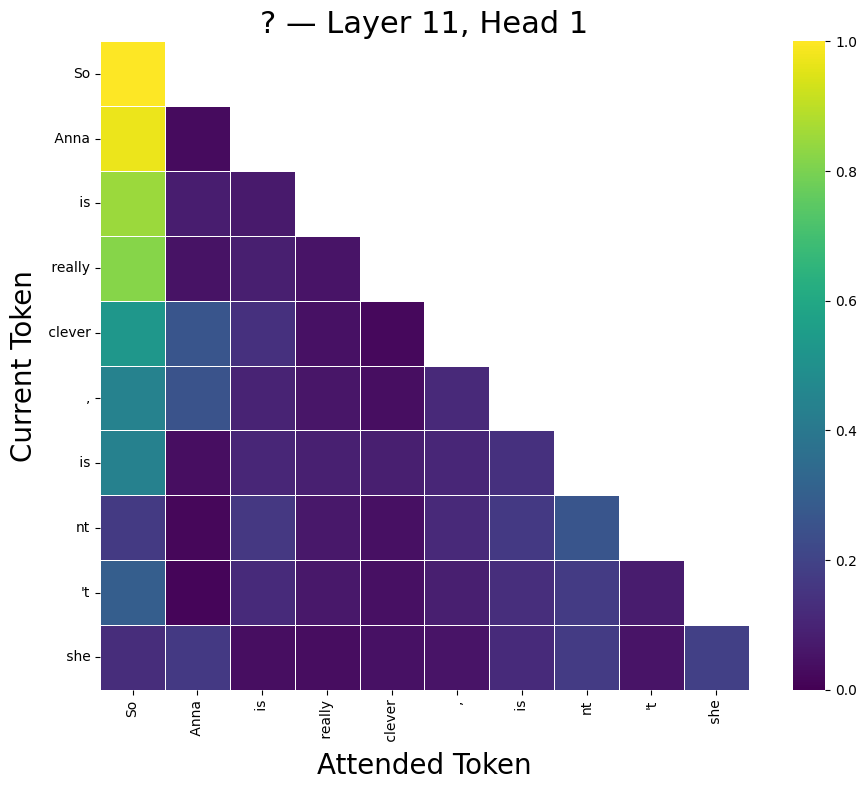

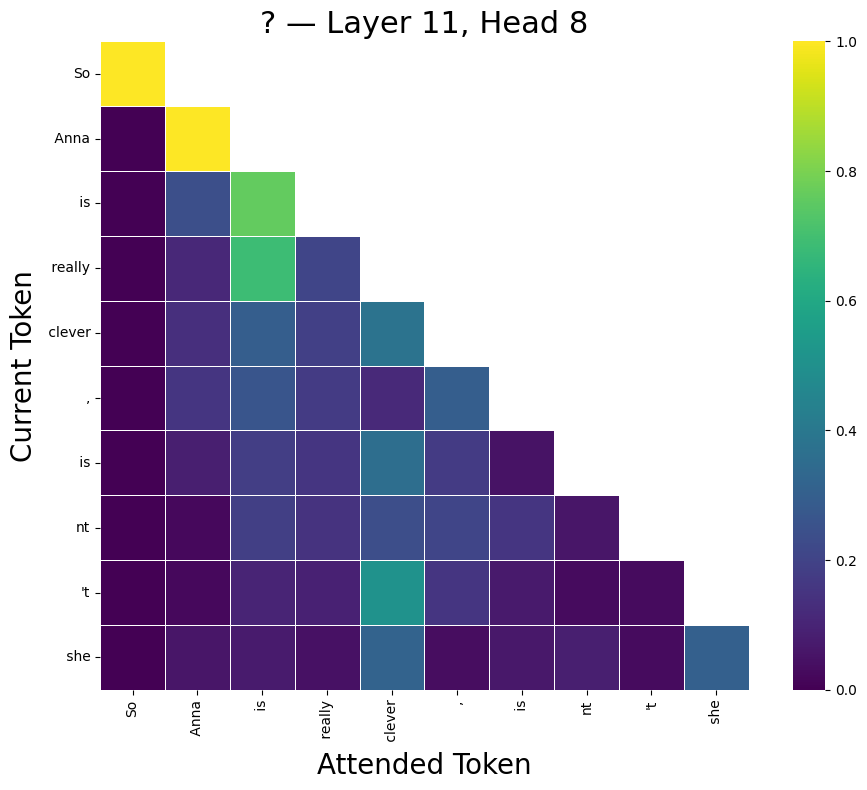

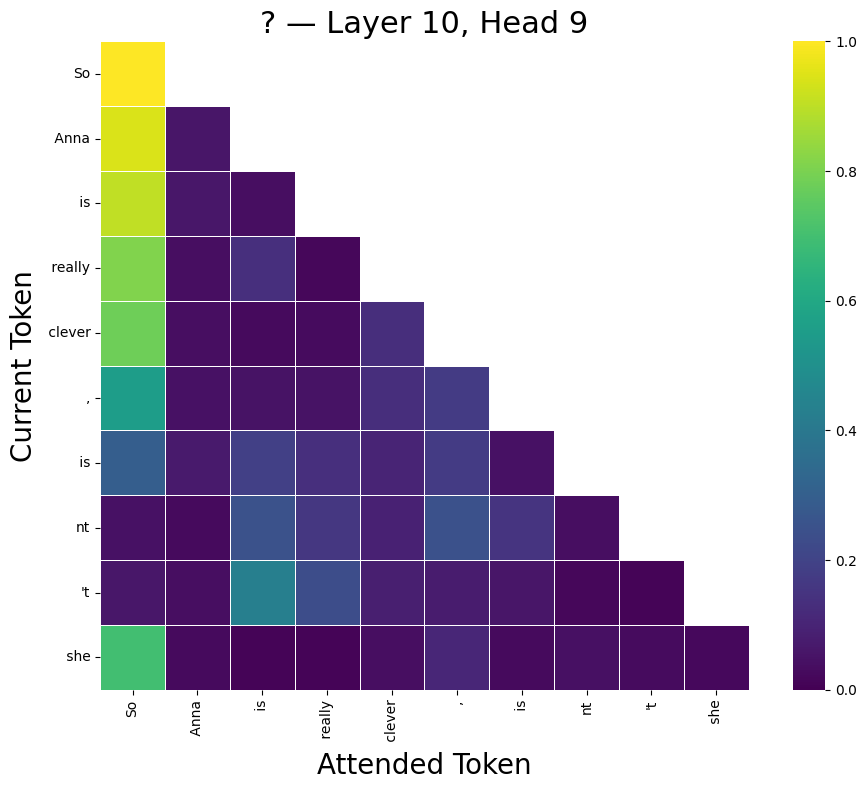

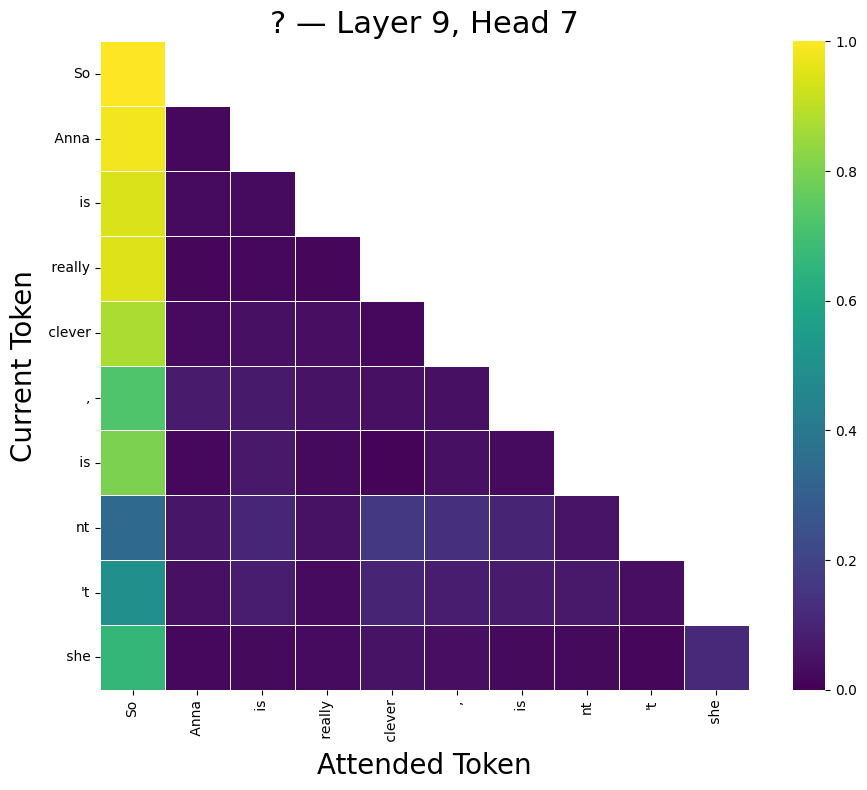

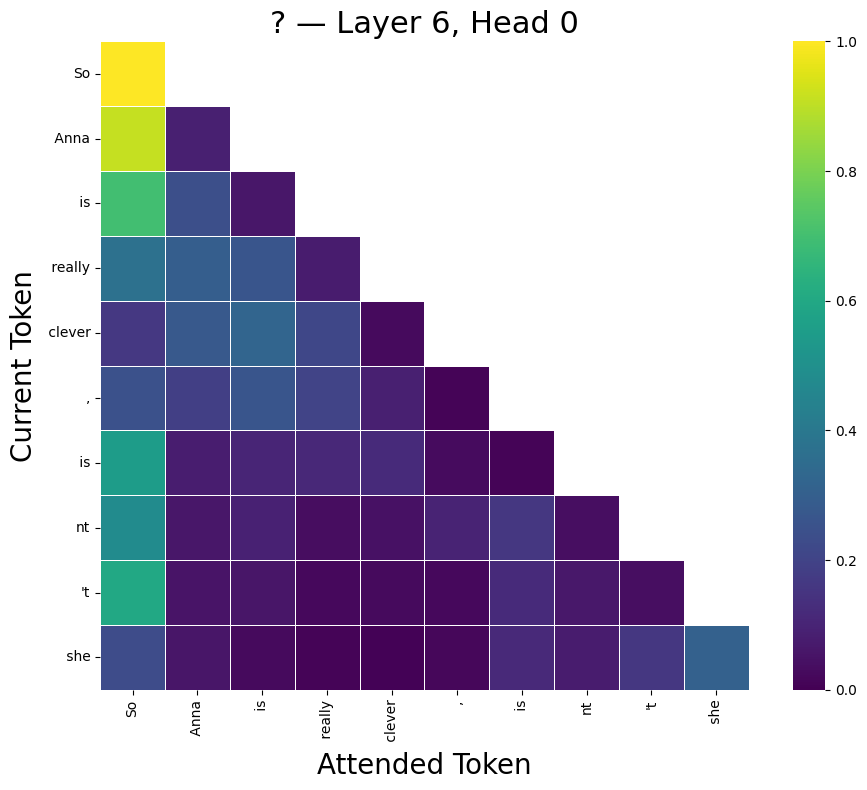

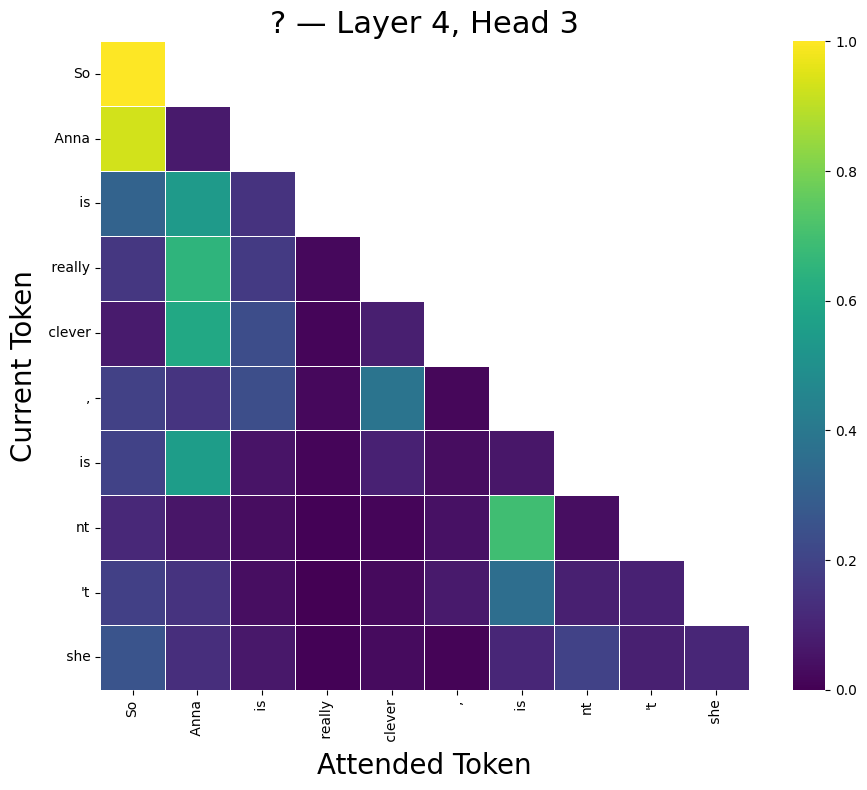

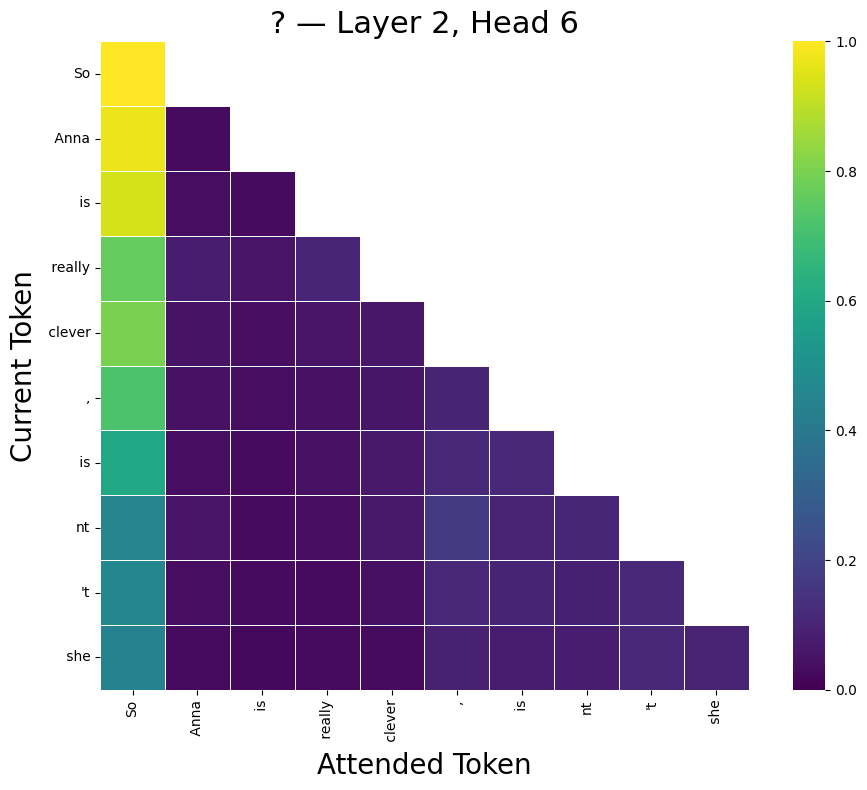

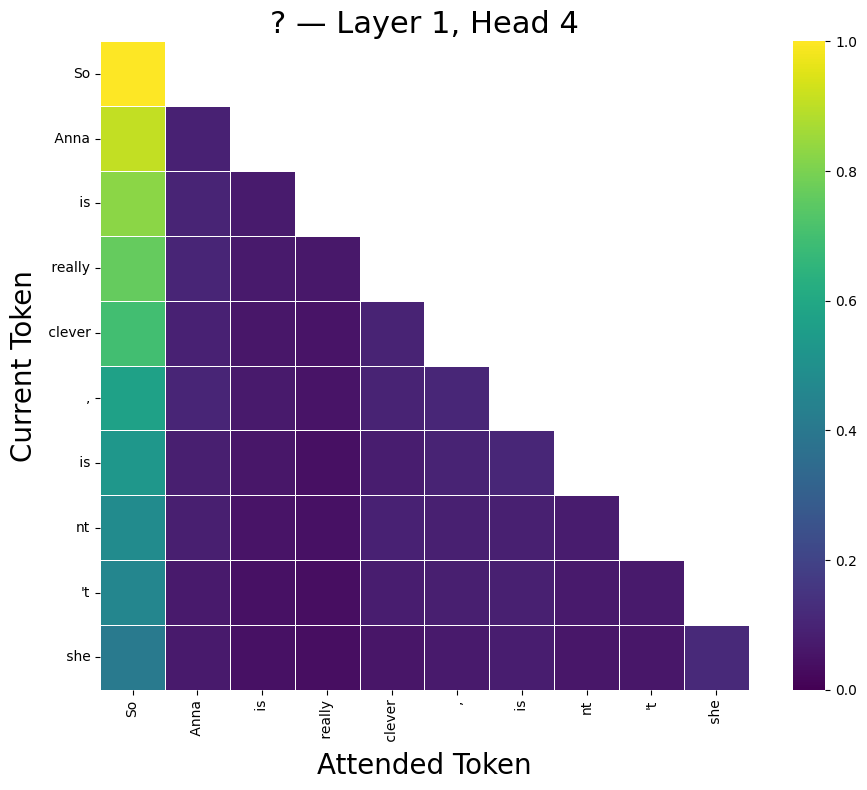

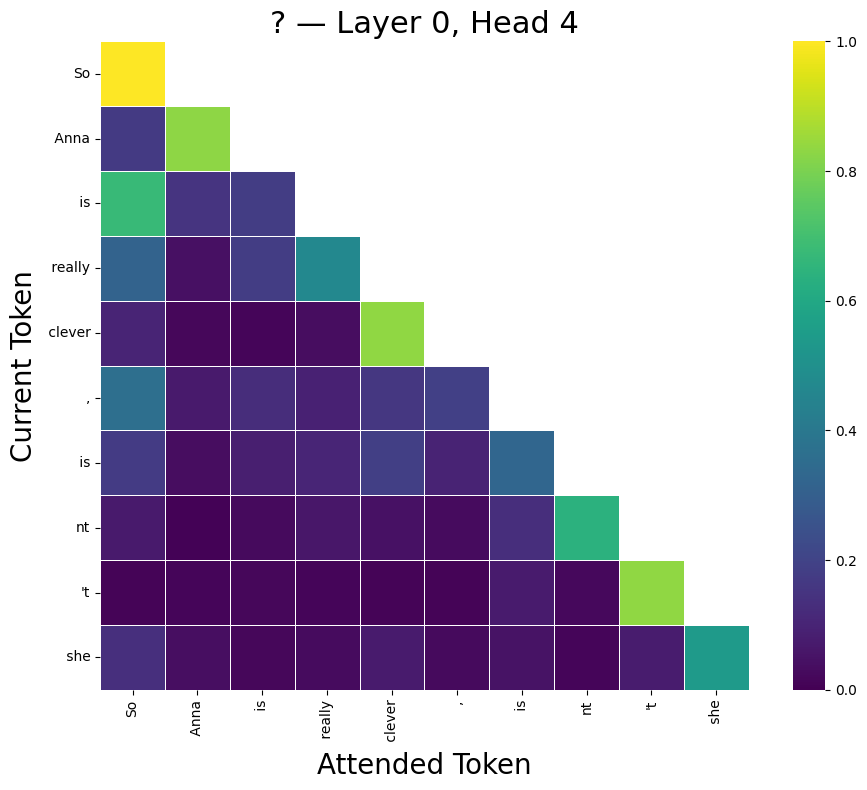

In [279]:
from utils.utils import activation_patterns

tokenizer = load_tokenizer(args.model_name)

model = load_transformer(args.model_name, output_attentions=True)
#model=load_hooked_transformer(args.model_name, device=args.device)
args.prepend_bos =False
dataset = load_dataset(
    args.task, 
    tokenizer,
    N =1, 
    seed=20, 
    device=args.device, 
    model_name=args.model_name, 
    prepend_bos=False, 
    remove_target_token=False
)
predict_target_token(model_hooked, dataset, eval_tokenizer, device=args.device, n=1, use_corrupted=True)

predict_target_token(model_hooked, dataset, eval_tokenizer, device=args.device, n=1, use_corrupted=False)


# ----- activation patterns of all elements in a circuit -----
#activation_patterns(model=model, tokenizer=tokenizer, dataset=dataset, CIRCUIT=CIRCUIT)

# ----- activation patterns of specific layer and head elements -----
activation_patterns(
    model=model, 
    tokenizer=tokenizer,
    dataset=dataset,
    CIRCUIT=CIRCUIT,
    activation_type="clean", #"clean", "corrupted", "difference"
    save=False,
    show=True,
    out_path=f"{args.out_path}/{args.model_name}/{args.task}",
    title="?"
    
    
    ) #layer_list=[14] , head_list=[3], is_corrupted=True)